# Session 1-2 Notebook for System Biology of Aging 
This notebook is part of the first session of the 2024 Systems Biology of Aging Workshop. But don't worry about setup, all of the files and R packages should be installed in the the Sagemaker environment.

This Notebook will use the "custom-R" kernel. Double check that this is correct by looking in the top right corner.

> * Multi-Omic WGCNA
> ** Integrate Omics
> ** Correlate with frailty
> ** Multiomic ssgsea

## Setup
The next couple blocks of code will load the R packages into our environment and set some options for nicer visualizaions.

In [3]:
# Load packages, one per line for clarity
suppressMessages(library("tidyverse", quietly = TRUE, warn.conflicts=FALSE))
suppressMessages(library("ggplot2", quietly = TRUE, warn.conflicts=FALSE))
suppressMessages(library("WGCNA", quietly = TRUE, warn.conflicts=FALSE))
suppressMessages(library("clusterProfiler", quietly = TRUE, warn.conflicts=FALSE))
suppressMessages(library("gplots", quietly = TRUE, warn.conflicts=FALSE))
suppressMessages(library("scales", quietly = TRUE, warn.conflicts=FALSE))
suppressMessages(library("Matrix", quietly = TRUE, warn.conflicts=FALSE))
suppressMessages(library("colorspace", quietly = TRUE, warn.conflicts=FALSE))
suppressMessages(library("multiGSEA", quietly = TRUE, warn.conflicts=FALSE))
# Other options
source("Scripts/Workshop_scripts.R") # Functions for plotting
options(stringsAsFactors=FALSE)#Required for WGCNA
enableWGCNAThreads(nThreads=2) # 
options(repr.plot.width=12, repr.plot.height=12)#Default=7x7
options(repr.matrix.max.rows=75, repr.matrix.max.cols=20)
options(warn=-1)

Allowing parallel execution with up to 2 working processes.


In [4]:
mets <- read_delim("./Session1_files/metabolites_baseline.tsv", show_col_types = FALSE)
prots <- read_delim("./Session1_files/proteins_baseline.tsv", show_col_types = FALSE)
clin <- read_delim("./Session1_files/chemistries_baseline.tsv", show_col_types = FALSE)

# Load meta data
meta_protein = read_delim("../data/arivale_snapshot_ISB_2019-05-10_0053/proteomics_metadata.tsv", skip=13, delim='\t', show_col_types = FALSE)

# Metabolites
meta_metabolites = read_delim("../data/arivale_snapshot_ISB_2019-05-10_0053/metabolomics_metadata.tsv", skip=13, delim='\t', show_col_types = FALSE)
fr_measures = read_delim("../data/frailty/combination_fi_040124.csv", show_col_types = FALSE)

fr_measures_key = read_delim("../Useful_Files/FI_Features.txt", show_col_types = FALSE, delim="\t")

New names:
• `` -> `...1`


Merge each dataframe together to create a multiomics dataframe that contains all shared participants. 

In [5]:
# Drop clinical lab tests that were used to generate lab_fi.
clin_no_frail <- clin[!colnames(clin) %in% fr_measures_key$Feature]

cm_df <- merge(clin_no_frail, mets, by="public_client_id")
pf_df <- merge(prots, fr_measures, by="public_client_id")
in_df <- merge(cm_df, pf_df, by="public_client_id")
dim(clin)
dim(mets)
dim(prots)
dim(fr_measures)
dim(in_df)
# Drop id column and get features
num.analytes <- setdiff(unique(c(colnames(clin),colnames(mets),colnames(prots))),'public_client_id')
num_df <- as.matrix(in_df[,colnames(in_df) %in% num.analytes])
rownames(num_df) <- in_df$public_client_id
meta <- in_df[,colnames(in_df) %in% colnames(fr_measures)]
head(num_df)

[1] 4878  129

[1] 2033 1051

[1] 2839 1196

[1] 3090   83

[1]  900 2426

,"ADIPONECTIN, SERUM","ANTIOXID CAP, TOTAL",ARACHIDONIC ACID,"ARSENIC, BLOOD",BASOPHILS,BASOPHILS ABSOLUTE,"BILIRUBIN, DIRECT","BILIRUBIN, INDIRECT",BUN/CREAT RATIO,"COPPER, RBC",⋯,ONC3_Q9NTU7(CBLN4),ONC3_Q9P1Z2(CALCOCO1),ONC3_Q9UDT6(CLIP2),ONC3_Q9UHD8(SEPT9),ONC3_Q9UJY5(GGA1),ONC3_Q9UMF0(ICAM5),ONC3_Q9Y2B0(CNPY2),ONC3_Q9Y5K2(KLK4),ONC3_Q9Y5K8(ATP6V1D),ONC3_Q9Y644(RFNG)
01001621,11.8,NA,11.2,NA,1.0,0.10,NA,NA,20,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
01003555,5.2,NA,10.0,NA,0.0,0.00,NA,NA,12,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
01003758,7.5,NA,10.2,NA,0.0,0.00,NA,NA,17,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
01004551,26.6,NA,11.5,NA,1.0,0.00,NA,NA,15,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
01004760,16.0,1060.7,NA,3,1.1,0.06,0.1,0.3,18,0.61,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
01006225,12.9,NA,11.9,NA,0.0,0.00,NA,NA,16,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


## Data cleaning

In [6]:
## Filter samples and features based on WGCNA NA criteria (50%)

gsg = goodSamplesGenes(num_df, verbose = 3);
gsg$allOK
if (!gsg$allOK)
{
  # Optionally, print the gene and sample names that were removed:
  if (sum(!gsg$goodGenes)>0) 
     printFlush(paste("Removing genes:", paste(names(num_df)[!gsg$goodGenes], collapse = ", ")));
  if (sum(!gsg$goodSamples)>0) 
     printFlush(paste("Removing samples:", paste(rownames(num_df)[!gsg$goodSamples], collapse = ", ")));
  # Remove the offending genes and samples from the data:
  num_df = num_df[gsg$goodSamples, gsg$goodGenes]
}

dim(num_df)

 Flagging genes and samples with too many missing values...
  ..step 1
  ..Excluding 1126 genes from the calculation due to too many missing samples or zero variance.
  ..step 2


[1] FALSE

Removing genes: 


[1]  900 1217

# Clustering combined 'omics data

The abundance of two arbitrarily chosen proteins in proteomics data is typically positively correlated, as are arbitrarily chosen genes in transcriptome data. We can therefore choose to use the power functions typically used in WGCNA analyses, or the more general sigmoid functions, to convert correlations into adjacencies (or distances) for clustering proteins in WGCNA.

## Correlations



In [7]:
# Get the names of remaining analytes overall (all.analytes) by category
cat.prots <- intersect(colnames(prots),colnames(num_df))
cat.mets  <- intersect(colnames(mets),colnames(num_df))
cat.clin  <- intersect(colnames(clin),colnames(num_df))
all.analytes <- c(cat.prots,cat.mets,cat.clin)
print("Proteins")
print(length(cat.prots))
print("Metabolites")
print(length(cat.mets))
print("Metabolites")
print(length(cat.clin))
print("All analytes")
print(length(all.analytes))
n.analytes <- length(all.analytes)

# To compute correlations, features must be numeric. We will use Spearman
all_df <- num_df[,all.analytes]

[1] "Proteins"
[1] 276
[1] "Metabolites"
[1] 892
[1] "Metabolites"
[1] 49
[1] "All analytes"
[1] 1217


In [8]:
# Running correlations is slow. We will load the data for now. The code to run the correlations is below-

omic_cor <- readRDS("Omics_Cor.Rds")
Z.pp <- omic_cor$Prot_Prot
Z.mm <- omic_cor$Met_Met
Z.cc <- omic_cor$Clin_Clin

Z.pm <- omic_cor$Prot_Met
Z.pc <- omic_cor$Prot_Clin
Z.mc <- omic_cor$Met_Clin

# # Within-category correlations
# Z.pp <- cor(all_df[,cat.prots], method = "s", use = 'pairwise.complete.obs')
# Z.mm <- cor(all_df[,cat.mets], method = "s", use = 'pairwise.complete.obs')
# Z.cc <- cor(all_df[,cat.clin], method = "s", use = 'pairwise.complete.obs')

# # Cross-category correlations
# Z.pm <- cor(all_df[,cat.prots], all_df[,cat.mets], method = "s", use = 'pairwise.complete.obs')
# Z.pc <- cor(all_df[,cat.prots], all_df[,cat.clin], method = "s", use = 'pairwise.complete.obs')
# Z.mc <- cor(all_df[,cat.mets], all_df[,cat.clin], method = "s", use = 'pairwise.complete.obs')
# The error message indicates that at least one analyte pair did not have at least 2 samples
# # with values for both analytes, resulting in an NA correlation. We replace this NA with a 0.
# length(which(is.na(Z.pm)))
# length(which(is.na(Z.pc)))
# length(which(is.na(Z.mc)))
# Z.mc[is.na(Z.mc)] <- 0
# length(which(is.na(Z.mc)))

In [9]:
head(Z.pm)

,35(S-1-pyrroline-5-carboxylate),50(spermidine),55(1-methylnicotinamide),"62(12,13-DiHOME)",93(alpha-ketoglutarate),98(kynurenate),111(3-hydroxyisobutyrate),112(3-hydroxy-3-methylglutarate),117(homovanillate (HVA)),132(3-phosphoglycerate),⋯,"100022004(bilirubin degradation product, C16H18N2O5 (2)**)","100022005(bilirubin degradation product, C17H18N2O4 (1)**)","100022006(bilirubin degradation product, C17H18N2O4 (2)**)","100022007(bilirubin degradation product, C17H18N2O4 (3)**)","100022008(bilirubin degradation product, C17H20N2O5 (1)**)","100022009(bilirubin degradation product, C17H20N2O5 (2)**)",100022013(tetrahydrocortisol glucuronide),"100022041(N,N-dimethyl-pro-pro)",100022120(oxindolylalanine),100022127(tetrahydrocortisone glucuronide (5))
CVD2_O00182(LGALS9),0.005924608,0.08131706,-0.11148546,-0.186738233,0.15953430,0.17176005,0.012859806,0.25810641,0.04434937,0.007182508,⋯,-0.06753565,-0.084756057,-0.05756857,-0.078788039,-0.067067263,-0.076730897,0.33385125,0.12479364,-0.228794543,0.2719613
CVD2_O00220(TNFRSF10A),0.018769637,0.06493884,-0.10575295,-0.077827518,0.10341529,0.07558855,0.008403973,0.16673633,0.03323773,0.017250029,⋯,-0.18006292,-0.187039473,-0.16682888,-0.152410341,-0.122751871,-0.136780213,0.14231950,-0.01752958,-0.200818577,0.1150599
CVD2_O00253(AGRP),0.045667549,0.10394595,-0.06807791,0.002838613,0.04582790,0.08670744,0.087665997,0.02034631,0.01877245,0.056835130,⋯,0.01136024,0.069522048,0.01896984,0.045688204,0.011771255,-0.005036027,0.16582483,0.13202589,-0.008231399,0.1759517
CVD2_O14763(TNFRSF10B),0.016031354,0.05783473,-0.07279765,-0.049694684,0.13214383,0.20037848,-0.001709203,0.30559611,0.18919850,0.048487736,⋯,-0.07095283,-0.090929589,-0.05328032,-0.086084299,-0.083184821,-0.085047248,0.24820444,0.23744980,-0.188769001,0.1780513
CVD2_O14836(TNFRSF13B),0.053235505,0.08274404,-0.08727578,-0.043210697,0.06388755,0.08155153,0.009924072,0.06829308,0.03144587,0.077633565,⋯,-0.02614308,-0.009356306,-0.01710640,-0.006116311,-0.009282181,-0.019711402,0.09658881,0.03854585,-0.094122132,0.1187871
CVD2_O43915(FIGF),0.062342033,-0.03539306,0.05679604,0.099873019,-0.03351691,-0.08324942,-0.061313217,0.06272715,0.04609177,-0.075762602,⋯,-0.01529483,-0.006415935,-0.04307634,-0.033051257,-0.048369972,-0.034841691,-0.20529587,-0.02656868,0.091496948,-0.1543295


### Modeling protein-protein correlations


In [10]:
# Estimate coefficients for a Beta distribution by the method of moments
# i.e. by computing parameters that match the mean and variance of the "background" model (initially: all observed correlations)
Z.unique <- Z.pp[row(Z.pp) < col(Z.pp)] # unique, non-self correlations
x <- (1+Z.unique)/2
mZ <- mean(x)
s2Z <- var(x)
v.pp <- mZ*(mZ*(1-mZ)/s2Z - 1)
w.pp <- (1-mZ)*(mZ*(1-mZ)/s2Z - 1)
print(paste("Protein-protein: rho_ij ~ Beta(v =",round(v.pp,3),",w =",round(w.pp,3),")"))

[1] "Protein-protein: rho_ij ~ Beta(v = 23.763 ,w = 17.251 )"


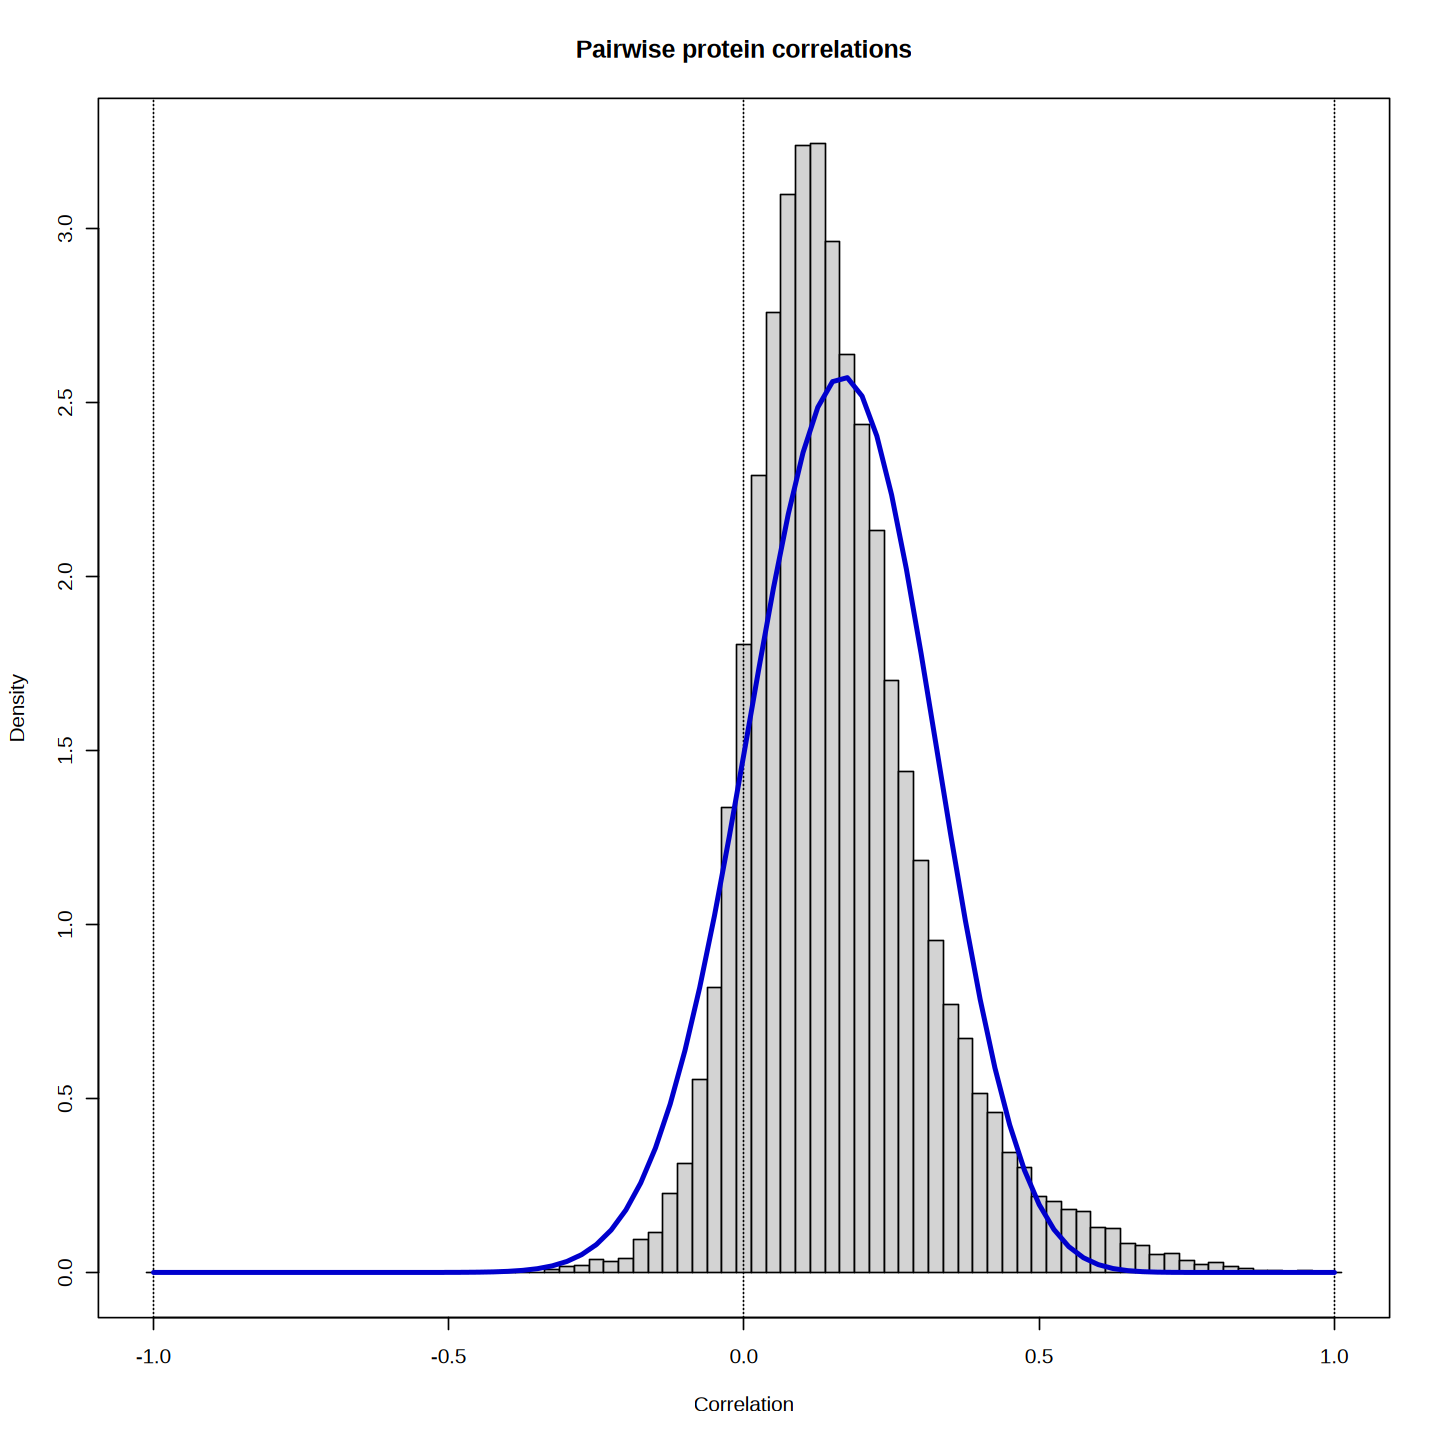

In [11]:
# Evaluate how well the model fits the background distribution
fine <- 40
Bs <- (c(-fine:(1+fine))-0.5)/fine
hist(Z.unique, breaks=Bs, xlab="Correlation", ylab="Density",
     main="Pairwise protein correlations", prob=TRUE)
box()
abline(v=c(-1:1),lty=3)
r <- c(-fine:fine)/fine
lines(r, dbeta((1+r)/2, v.pp, w.pp)/2, lwd=3, col="MediumBlue")

The model doesn't fit the background distribution well enough (by eye). We will adjust the parameters until the model fits.

[1] "Protein pairs: rho_ij ~ Beta(v = 38 ,w = 30 )"


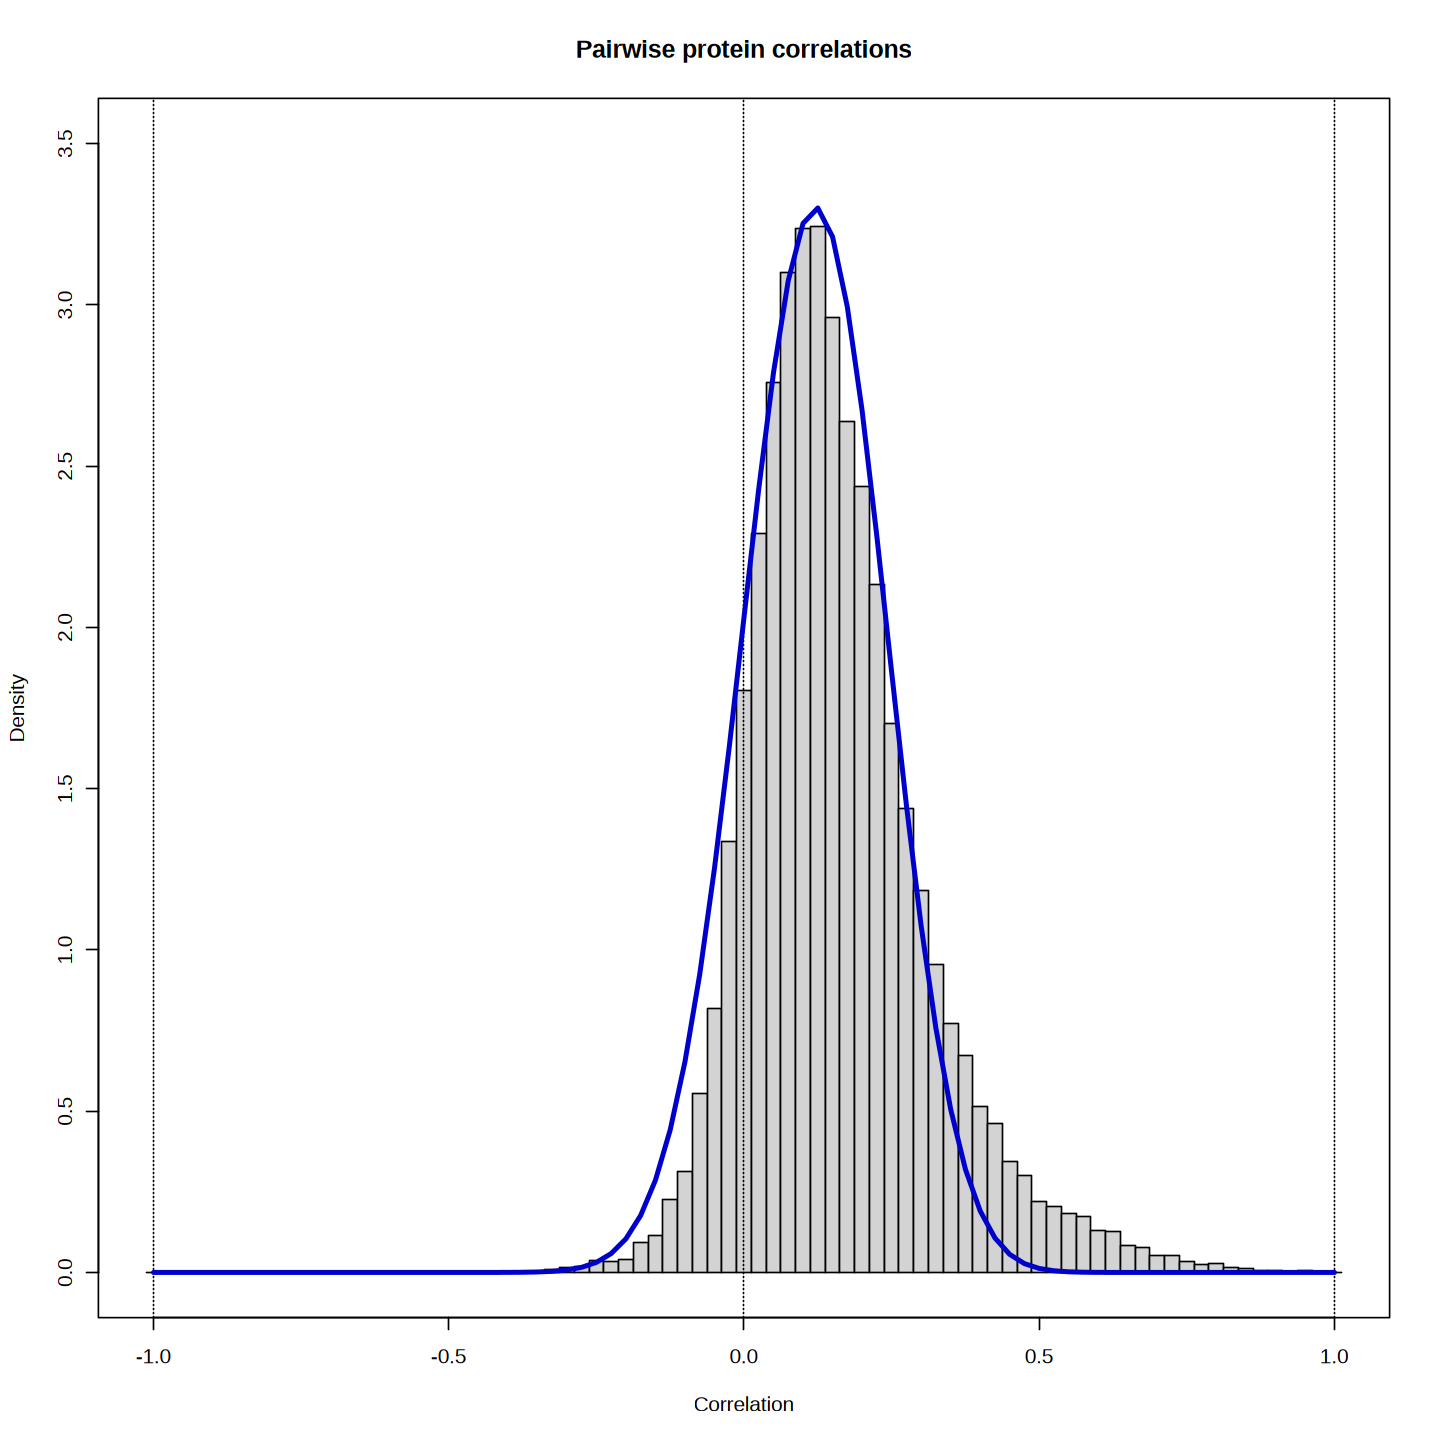

In [12]:
v.pp <- 38
w.pp <- 30
print(paste("Protein pairs: rho_ij ~ Beta(v =",round(v.pp,3),",w =",round(w.pp,3),")"))

fine <- 40
Bs <- (c(-fine:(1+fine))-0.5)/fine
hist(Z.unique, breaks=Bs, xlab="Correlation", ylab="Density", ylim=c(0,3.5),
     main="Pairwise protein correlations", prob=TRUE)
box()
abline(v=c(-1:1),lty=3)

r <- c(-fine:fine)/fine
lines(r, dbeta((1+r)/2, v.pp, w.pp)/2, lwd=3, col="MediumBlue")

### Modeling by category: metabolite-metabolite

In [13]:
Z.unique <- as.vector(Z.mm[row(Z.mm) < col(Z.mm)]) # unique, non-self correlations

v.mm <- 59.31
w.mm <- 56.38
print(paste("Metabolite pairs: rho_ij ~ Beta(v =",round(v.mm,3),",w =",round(w.mm,3),")"))

[1] "Metabolite pairs: rho_ij ~ Beta(v = 59.31 ,w = 56.38 )"


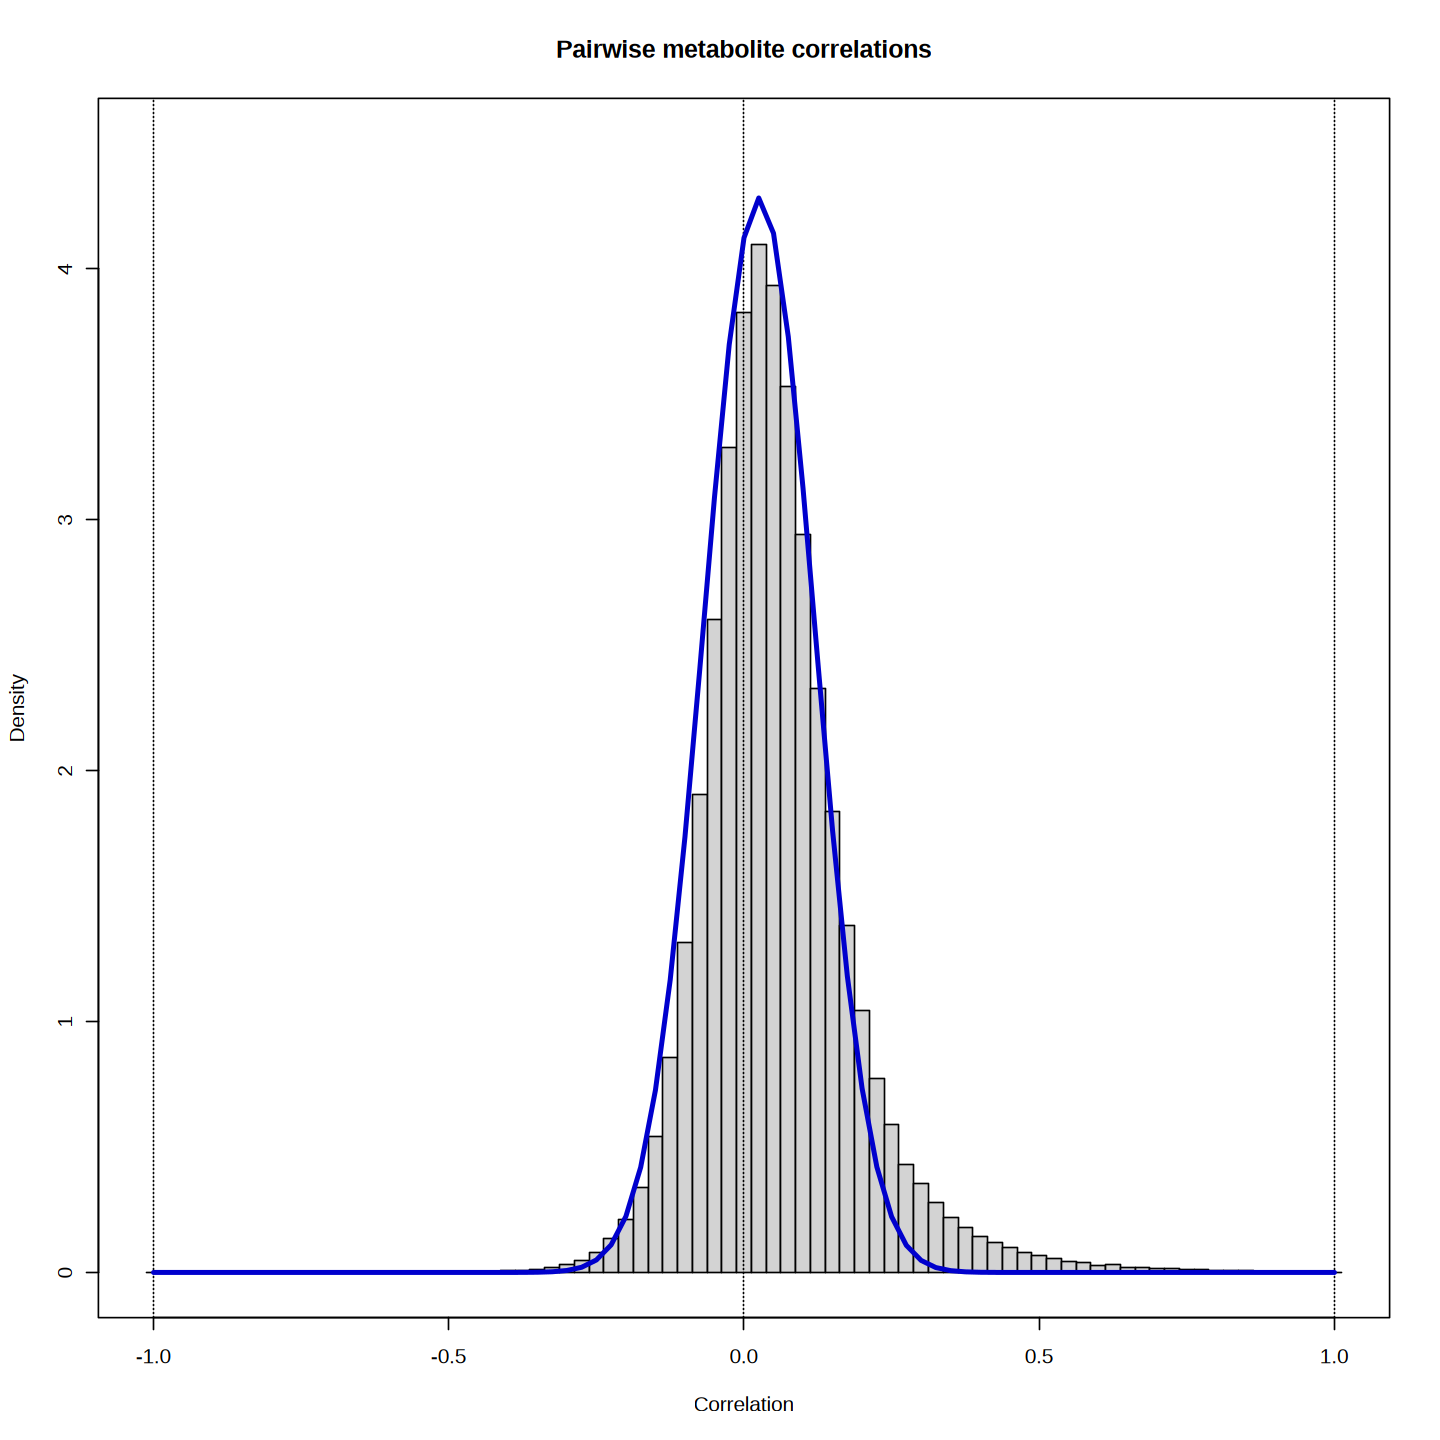

In [14]:
# Metabolite pair correlations

fine <- 40
Bs <- (c(-fine:(1+fine))-0.5)/fine
hist(Z.unique, breaks=Bs, xlab="Correlation", ylab="Density", ylim=c(0,4.5),
     main="Pairwise metabolite correlations", prob=TRUE)
box()
abline(v=c(-1:1),lty=3)

r <- c(-fine:fine)/fine
lines(r, dbeta((1+r)/2, v.mm, w.mm)/2, lwd=3, col="MediumBlue")

### Modeling by category: Clin-Clin

[1] "Metabolite pairs: rho_ij ~ Beta(v = 38 ,w = 37 )"


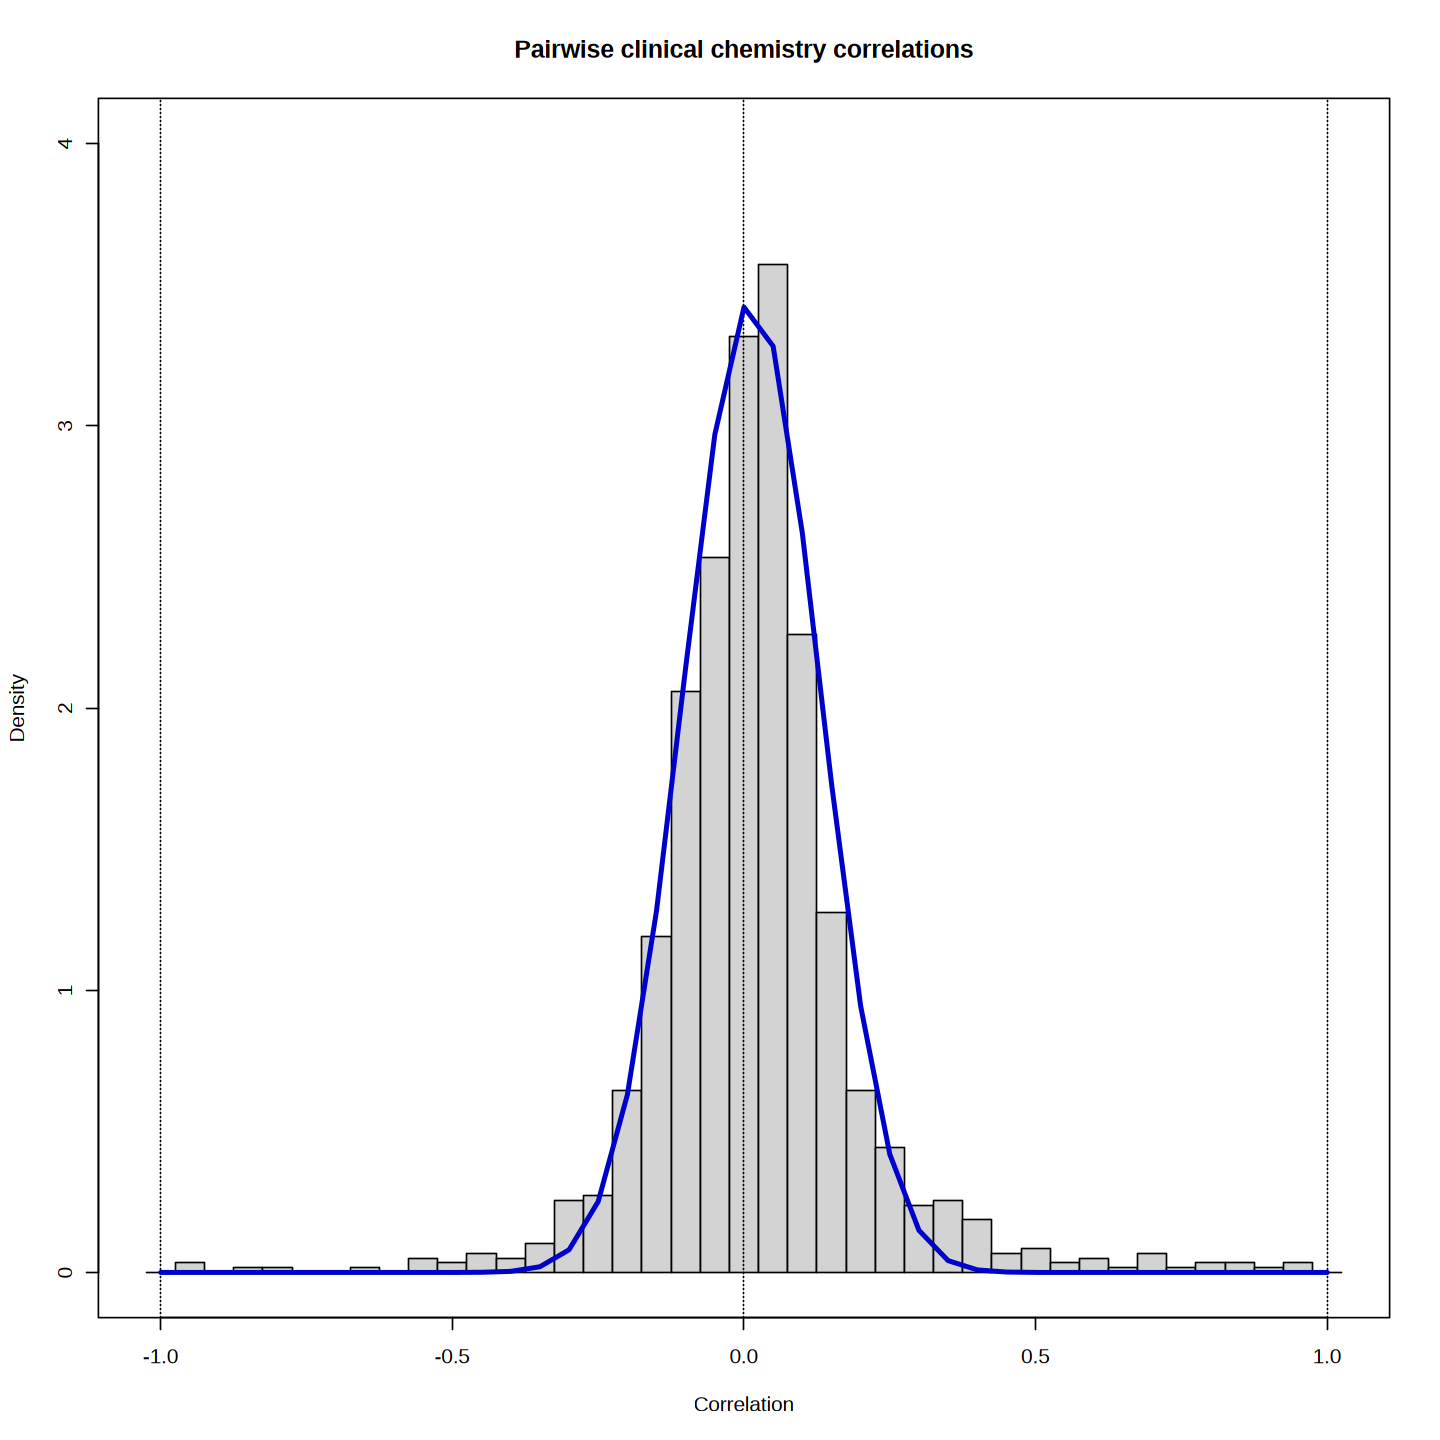

In [15]:
Z.unique <- as.vector(Z.cc[row(Z.cc) < col(Z.cc)]) # unique, non-self correlations

v.cc <- 38
w.cc <- 37
print(paste("Metabolite pairs: rho_ij ~ Beta(v =",round(v.cc,3),",w =",round(w.cc,3),")"))

fine <- 20
Bs <- (c(-fine:(1+fine))-0.5)/fine
hist(Z.unique, breaks=Bs, xlab="Correlation", ylab="Density", ylim=c(0,4),
     main="Pairwise clinical chemistry correlations", prob=TRUE)
box()
abline(v=c(-1:1),lty=3)

r <- c(-fine:fine)/fine
lines(r, dbeta((1+r)/2, v.cc, w.cc)/2, lwd=3, col="MediumBlue")

## Modeling cross-category correlations


### Modeling cross-category correlations: protein-metabolite

[1] 276 892

[1] "Protein-metabolite: rho_ij ~ Beta(v = 88 ,w = 85 )"


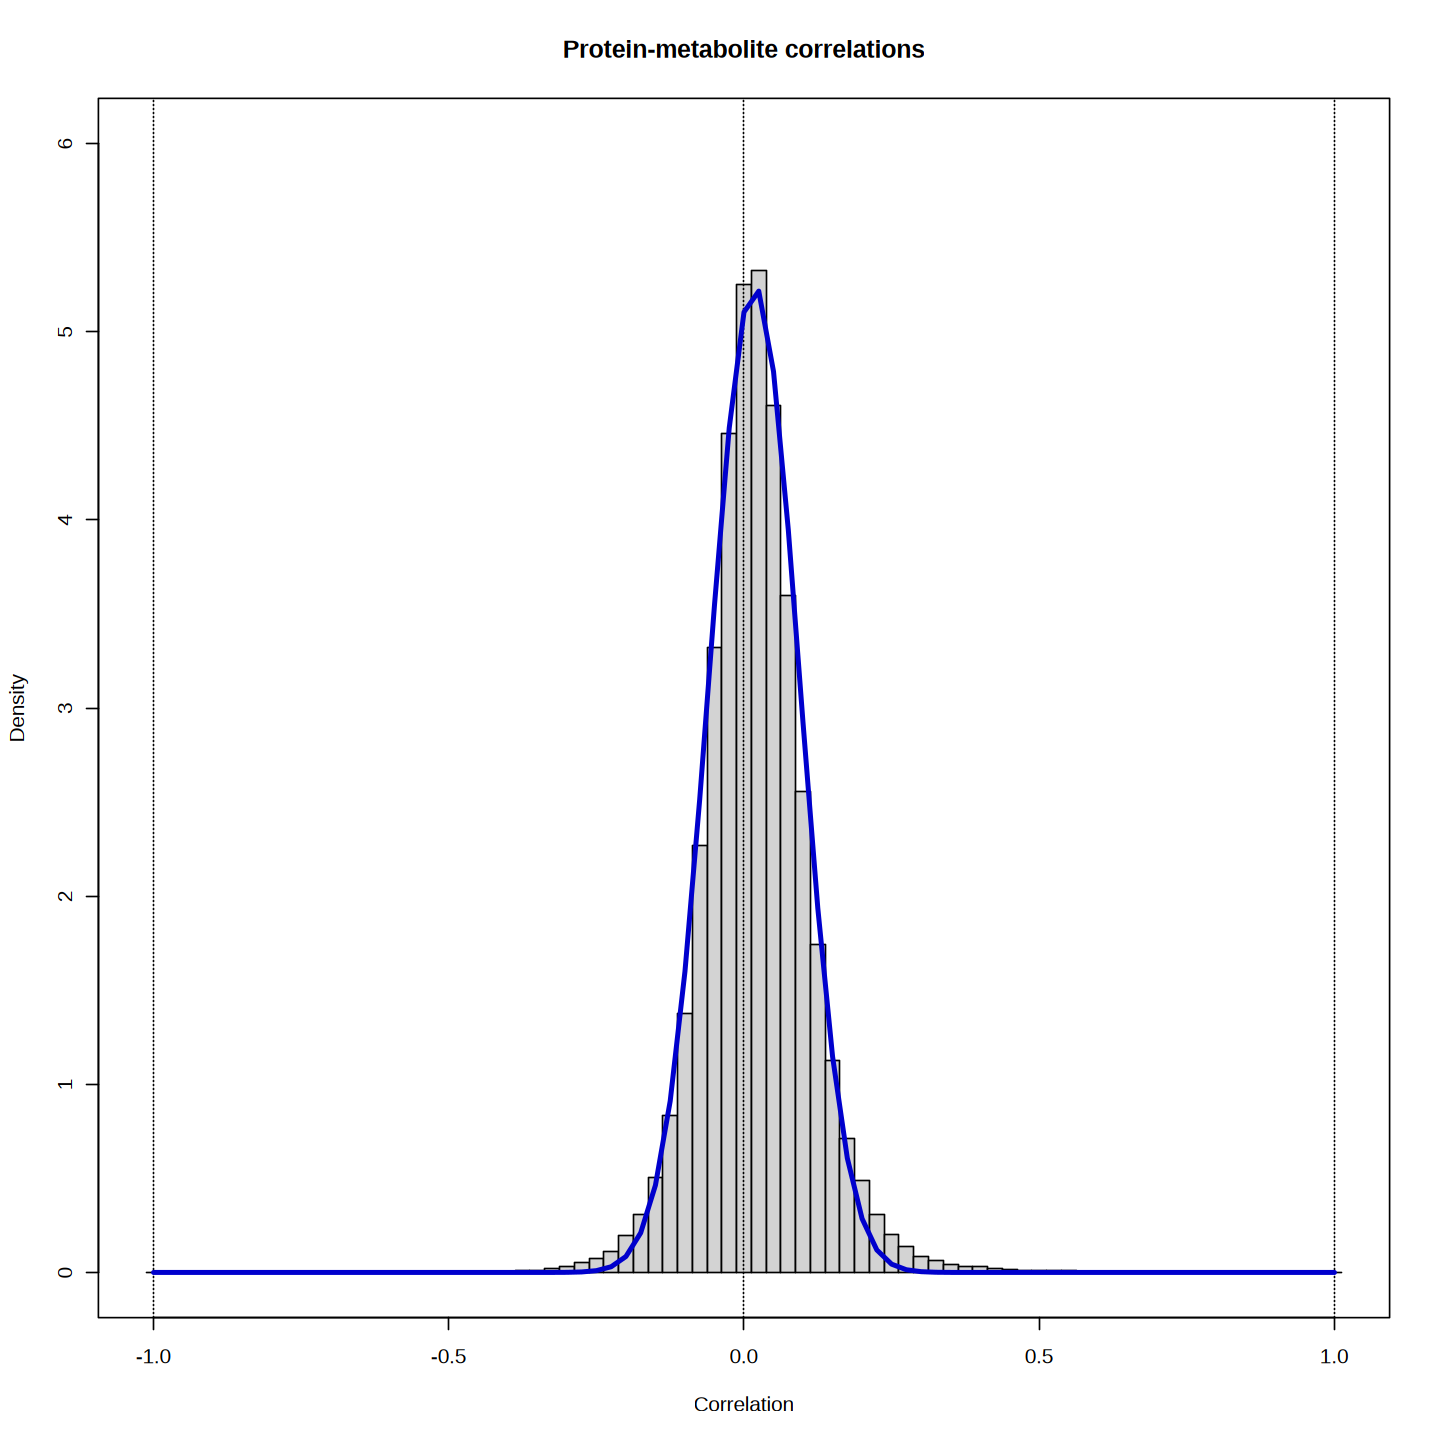

In [16]:
# Construct a background model by:
# 1. Find the mean and variance of the observed correlations
# 2. Estimate parameters and compare the background model to the histogram of observed correlations
# 3. Revise the mean and variance, recompute parameters, and compare again until satisfied with the fit to the background
#
dim(Z.pm)
Z.unique <- as.vector(Z.pm) # there are no self-comparisons, nor are there repeats due to symmetry
v.pm <- 88
w.pm <- 85 
print(paste("Protein-metabolite: rho_ij ~ Beta(v =",round(v.pm,3),",w =",round(w.pm,3),")"))

# The distribution of these cross-correlations is
# markedly narrower than either of the contributing 'omics

fine <- 40
Bs <- (c(-fine:(1+fine))-0.5)/fine
hist(Z.unique, breaks=Bs, xlab="Correlation", ylab="Density", ylim=c(0,6),
     main="Protein-metabolite correlations", prob=TRUE)
box()
abline(v=c(-1:1),lty=3)

r <- c(-fine:fine)/fine
lines(r, dbeta((1+r)/2, v.pm, w.pm)/2, lwd=3, col="MediumBlue")


### Modeling cross-category correlations: protein-clinical

[1] "Protein-clinical: rho_ij ~ Beta(v = 59 ,w = 57 )"


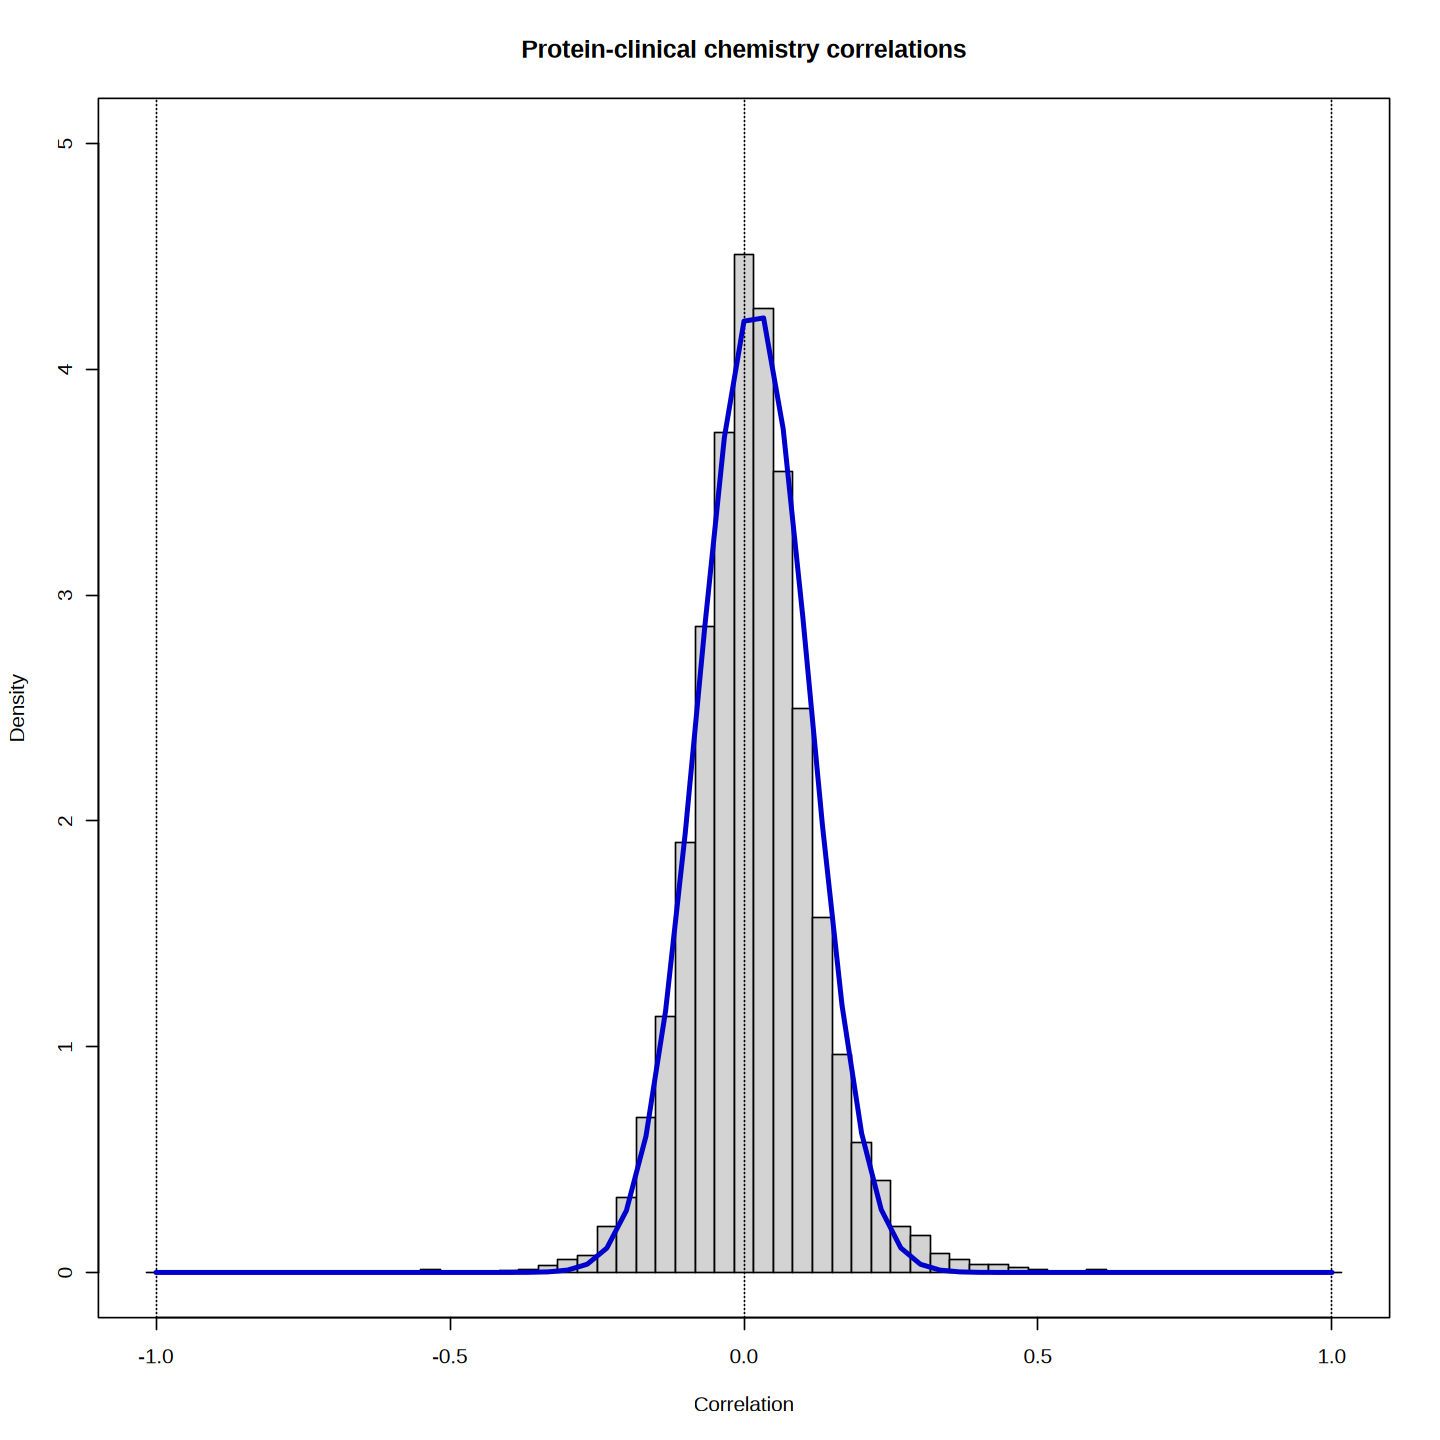

In [17]:
Z.unique <- as.vector(Z.pc) # unique, non-self correlations

v.pc <- 59
w.pc <- 57 
print(paste("Protein-clinical: rho_ij ~ Beta(v =",round(v.pc,3),",w =",round(w.pc,3),")"))

fine <- 30

Bs <- (c(-fine:(1+fine))-0.5)/fine
hist(Z.unique, breaks=Bs, xlab="Correlation", ylab="Density", ylim=c(0,5),
     main="Protein-clinical chemistry correlations", prob=TRUE)
box()
abline(v=c(-1:1),lty=3)

r <- c(-fine:fine)/fine
lines(r, dbeta((1+r)/2, v.pc, w.pc)/2, lwd=3, col="MediumBlue")

### Modeling cross-category correlations: metabolite-clinical

[1] "Signed: rho_ij ~ Beta(v = 62 ,w = 61 )"


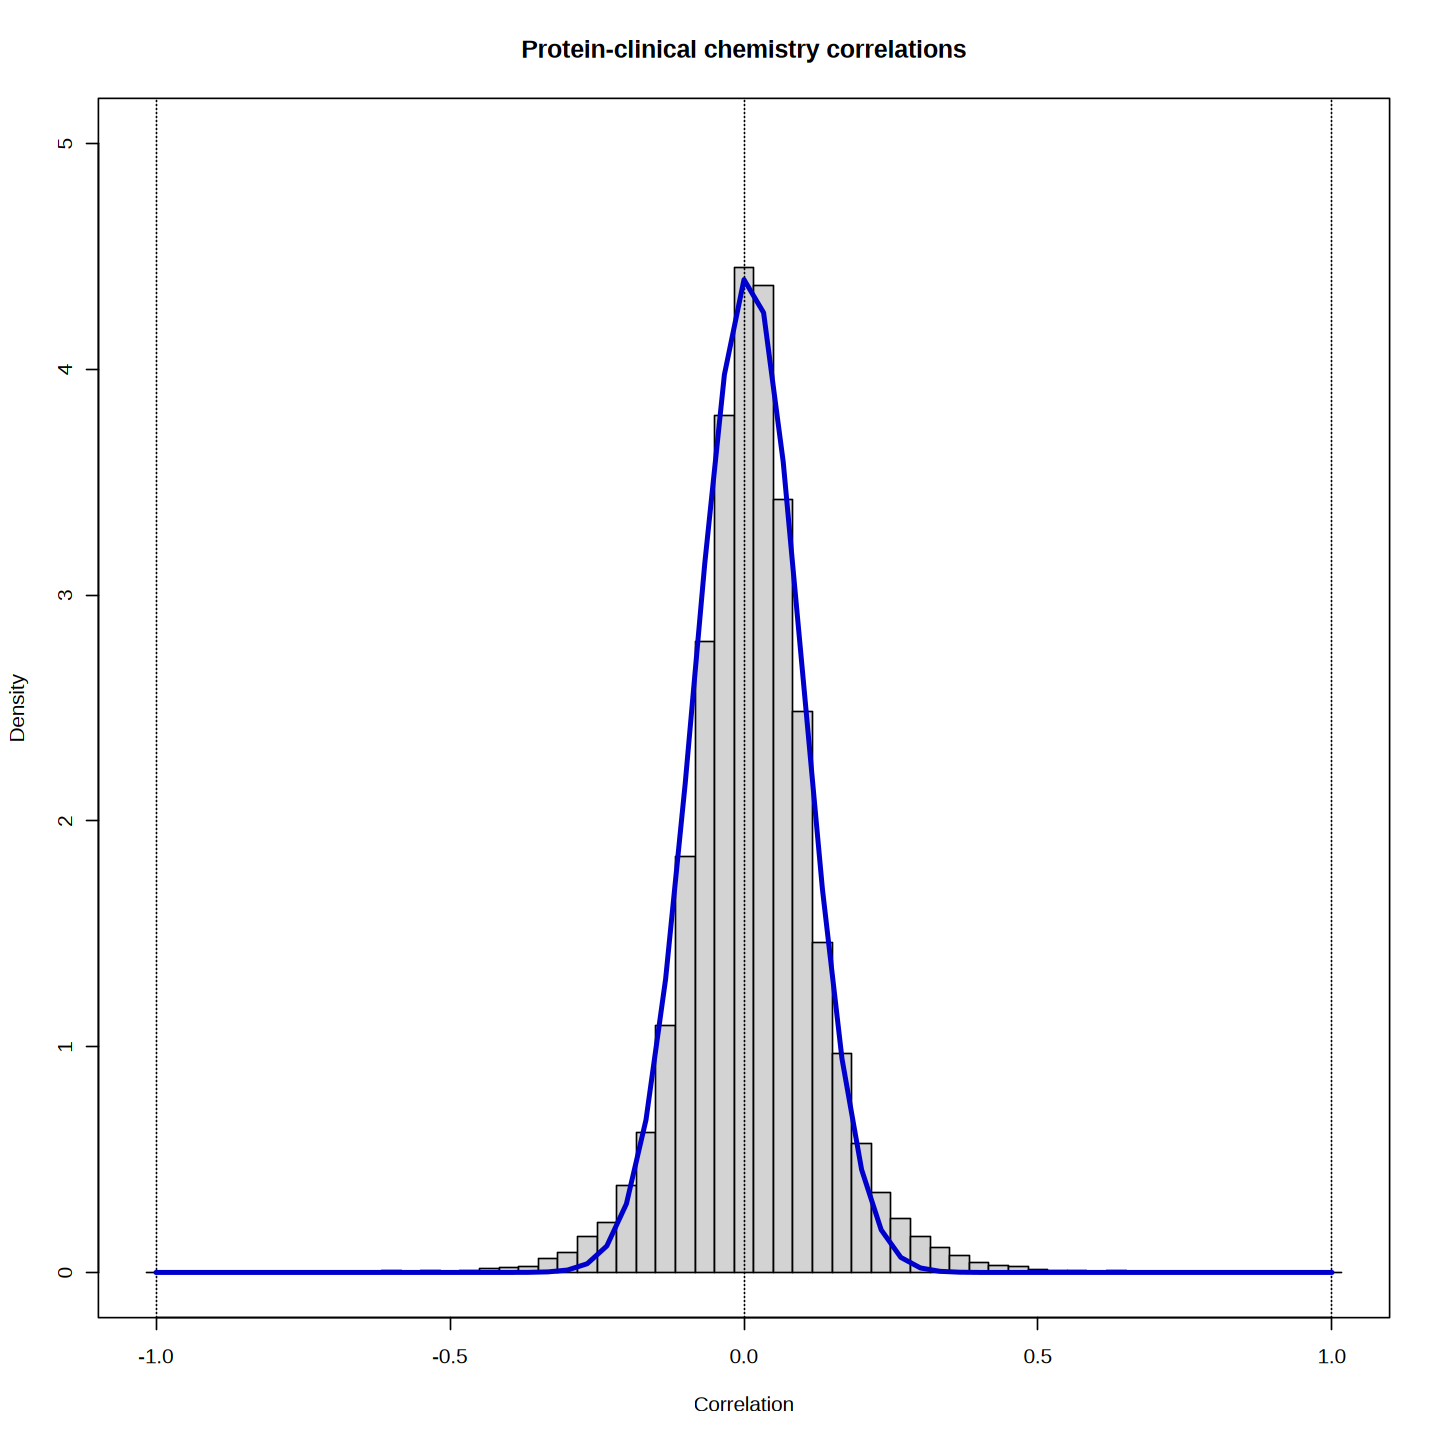

In [18]:
Z.unique <- as.vector(Z.mc) # unique, non-self correlations

v.mc <- 62
w.mc <- 61
print(paste("Signed: rho_ij ~ Beta(v =",round(v.mc,3),",w =",round(w.mc,3),")"))

fine <- 30
Bs <- (c(-fine:(1+fine))-0.5)/fine
hist(Z.unique, breaks=Bs, xlab="Correlation", ylab="Density", ylim=c(0,5),
     main="Protein-clinical chemistry correlations", prob=TRUE)
box()
abline(v=c(-1:1),lty=3)

r <- c(-fine:fine)/fine
lines(r, dbeta((1+r)/2, v.mc, w.mc)/2, lwd=3, col="MediumBlue")


## Merging correlations from disparate data subsets


In [19]:
# Centering the protein, metabolite, and clinical chemistry correlations
#
# The null distribution model is r ~ 2 Beta(v,w) - 1
# The centering (target) distribution is r_centered ~ 2 Beta(nu, nu) - 1
#
center.beta <- function(r, v, w, nu) {
    return(2*qbeta(pbeta((1 + r)/2, v, w), nu, nu) - 1)
}

nu.std <- 32 # A little wider than the actual distributions, and centered at 0

Zc.pp <- center.beta(Z.pp, v.pp, w.pp, nu.std)
Zc.mm <- center.beta(Z.mm, v.mm, w.mm, nu.std)
Zc.cc <- center.beta(Z.cc, v.cc, w.cc, nu.std)
Zc.pm <- center.beta(Z.pm, v.pm, w.pm, nu.std)
Zc.pc <- center.beta(Z.pc, v.pc, w.pc, nu.std)
Zc.mc <- center.beta(Z.mc, v.mc, w.mc, nu.std)

## Construct a complete, centered correlation matrix

[1] "Target: rho_ij ~ Beta(v = 32 ,w = 32 )"
[1] "Method of moments: rho_ij ~ Beta(v = 19.025 ,w = 18.055 )"


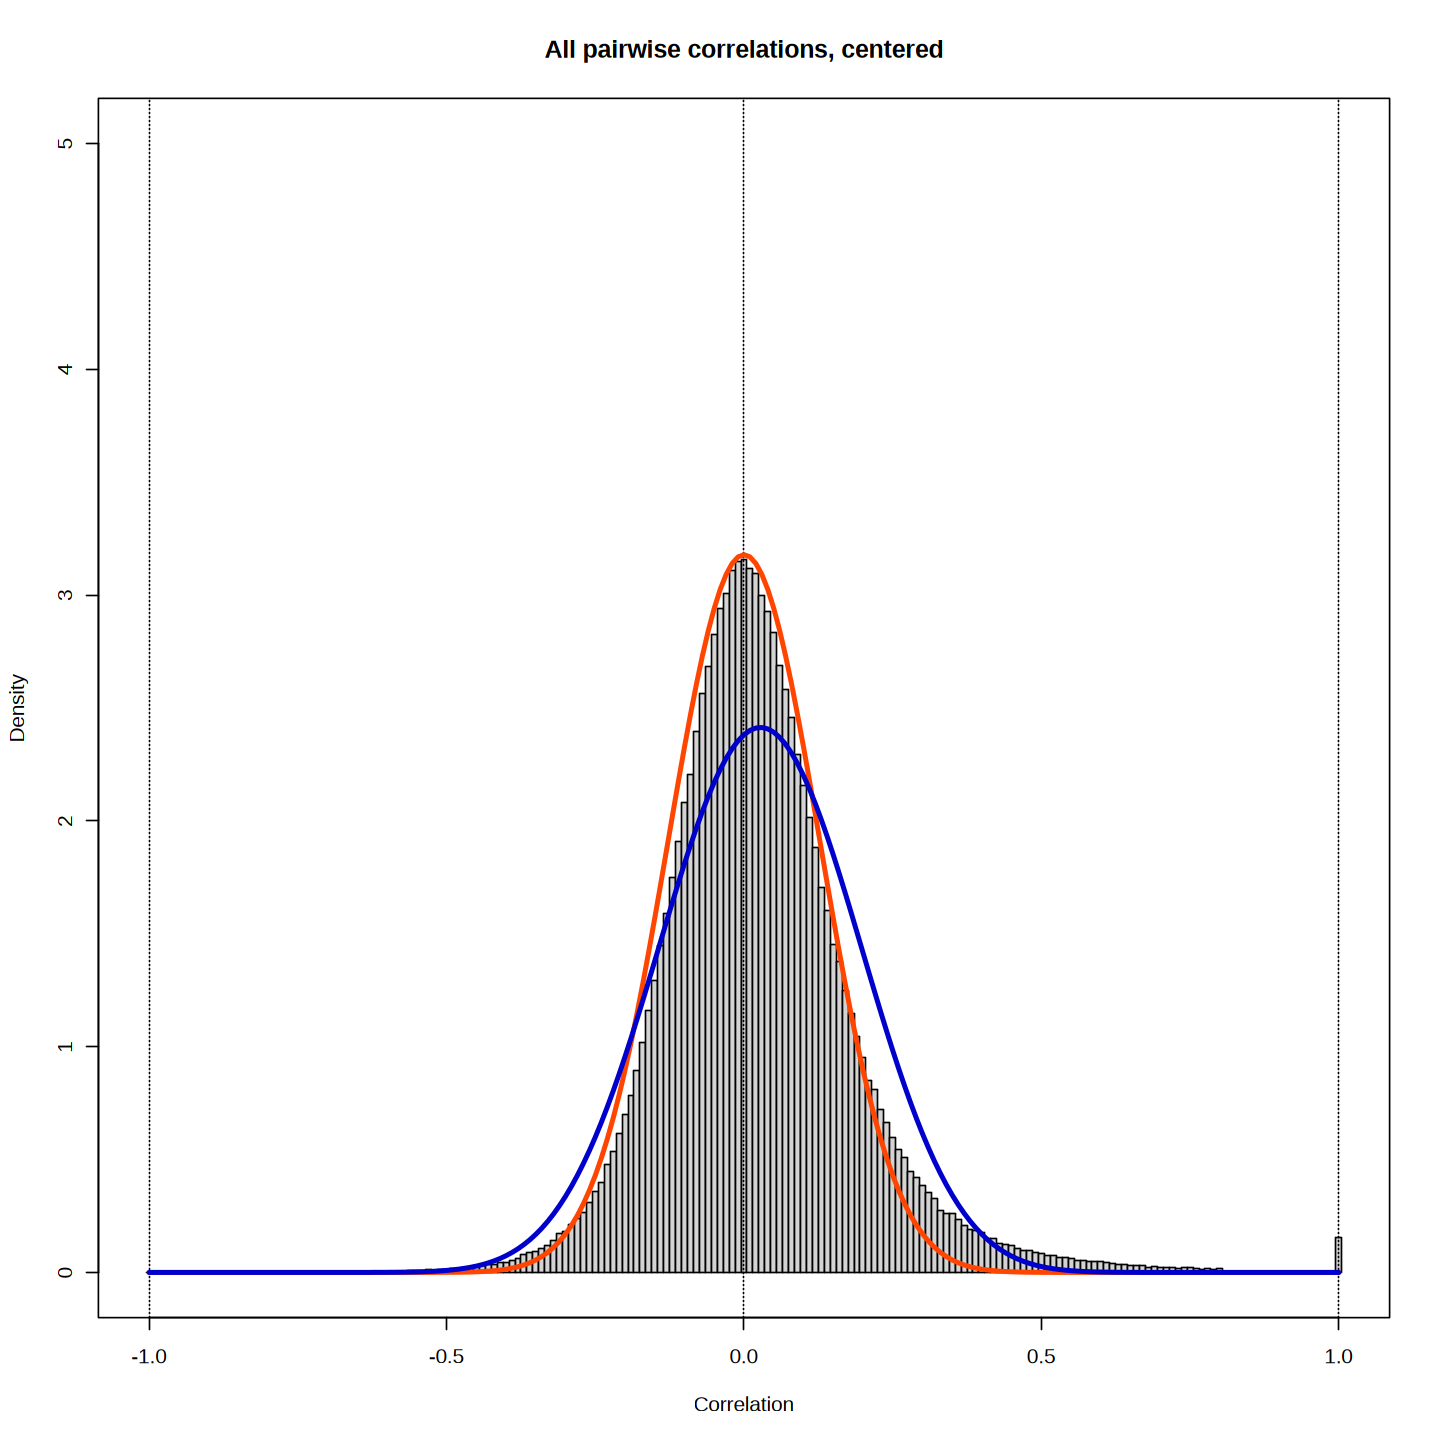

In [20]:
# Combined, centered correlations

all.analytes <- c(cat.prots,cat.mets,cat.clin)
Zc <- matrix(0, nrow = length(all.analytes),
                ncol = length(all.analytes))
rownames(Zc) <- all.analytes
colnames(Zc) <- all.analytes

###
# Block-structured correlation matrix
# Zc = [ PP     PM   PC |
#      | PM^T   MM   MC |
#      | PC^T  MC^T  CC ]
###
Zc[cat.prots, cat.prots] <- Zc.pp
Zc[cat.mets,  cat.mets]  <- Zc.mm
Zc[cat.clin,  cat.clin]  <- Zc.cc

Zc[cat.prots, cat.mets]  <- Zc.pm
Zc[cat.mets, cat.prots]  <- t(Zc.pm)

Zc[cat.prots, cat.clin]  <- Zc.pc
Zc[cat.clin, cat.prots]  <- t(Zc.pc)

Zc[cat.mets, cat.clin]  <- Zc.mc
Zc[cat.clin, cat.mets]  <- t(Zc.mc)

Z.unique <- Zc[row(Zc) < col(Zc)]
print(paste("Target: rho_ij ~ Beta(v =",round(nu.std,3),",w =",round(nu.std,3),")"))

x <- (1+Z.unique)/2
mZ <- mean(x)
s2Z <- var(x)
v.c <- mZ*(mZ*(1-mZ)/s2Z - 1)
w.c <- (1-mZ)*(mZ*(1-mZ)/s2Z - 1)
print(paste("Method of moments: rho_ij ~ Beta(v =",round(v.c,3),",w =",round(w.c,3),")"))


fine <- 100
Zc.unique <- as.vector(Zc[row(Zc) < col(Zc)])
Bs <- (c(-fine:(1+fine))-0.5)/fine
hist(Zc.unique, breaks=Bs, xlab="Correlation", ylab="Density", ylim=c(0,5),
     main="All pairwise correlations, centered", prob=TRUE)
box()
abline(v=c(-1:1),lty=3)

r <- c(-fine:fine)/fine
lines(r, dbeta((1+r)/2, nu.std, nu.std)/2, lwd=3, col="orangered")
lines(r, dbeta((1+r)/2, v.c, w.c)/2, lwd=3, col="MediumBlue")


These are now standardized correlations. The mean and variance of this distribution suggest a model (shown in blue) that fits less well than the standardizing model (in orange); this is a consequence of the differences between the models we fitted and the empirical distributions, and indicates that the enrichment of high correlations we observed in the individual 'omics distributions has been preserved. If we had used quantile normalization, the overabundance of high correlations would have been shifted to lower correlation values, and the fitted blue model would be identical to the standardizing model.

## Standard Signed WGCNA analysis (via a power function indicative of a scale-free network)

In [21]:

# Choose a set of soft-thresholding powers
powers = c(1:15)
# Call the network topology analysis function
sft <- invisible(pickSoftThreshold.fromSimilarity(Zc, powerVector = powers, blockSize=NULL, verbose=0))

Called from: pickSoftThreshold(similarity, dataIsExpr = FALSE, RsquaredCut = RsquaredCut, 
    powerVector = powerVector, removeFirst = removeFirst, nBreaks = nBreaks, 
    blockSize = blockSize, networkType = "signed", moreNetworkConcepts = moreNetworkConcepts, 
    verbose = verbose, indent = indent)
debug: SFT1 = scaleFreeFitIndex(k = khelp, nBreaks = nBreaks, removeFirst = removeFirst)
debug: datout[i, 2] = SFT1$Rsquared.SFT
debug: datout[i, 3] = SFT1$slope.SFT
debug: datout[i, 4] = SFT1$truncatedExponentialAdjRsquared
debug: datout[i, 5] = mean(khelp, na.rm = TRUE)
debug: datout[i, 6] = median(khelp, na.rm = TRUE)
debug: datout[i, 7] = max(khelp, na.rm = TRUE)
debug: if (moreNetworkConcepts) {
    Density = sum(khelp)/(nGenes * (nGenes - 1))
    datout[i, 8] = Density
    Centralization = nGenes * (max(khelp) - mean(khelp))/((nGenes - 
        1) * (nGenes - 2))
    datout[i, 9] = Centralization
    Heterogeneity = sqrt(nGenes * sum(khelp^2)/sum(khelp)^2 - 
        1)
    datout[i

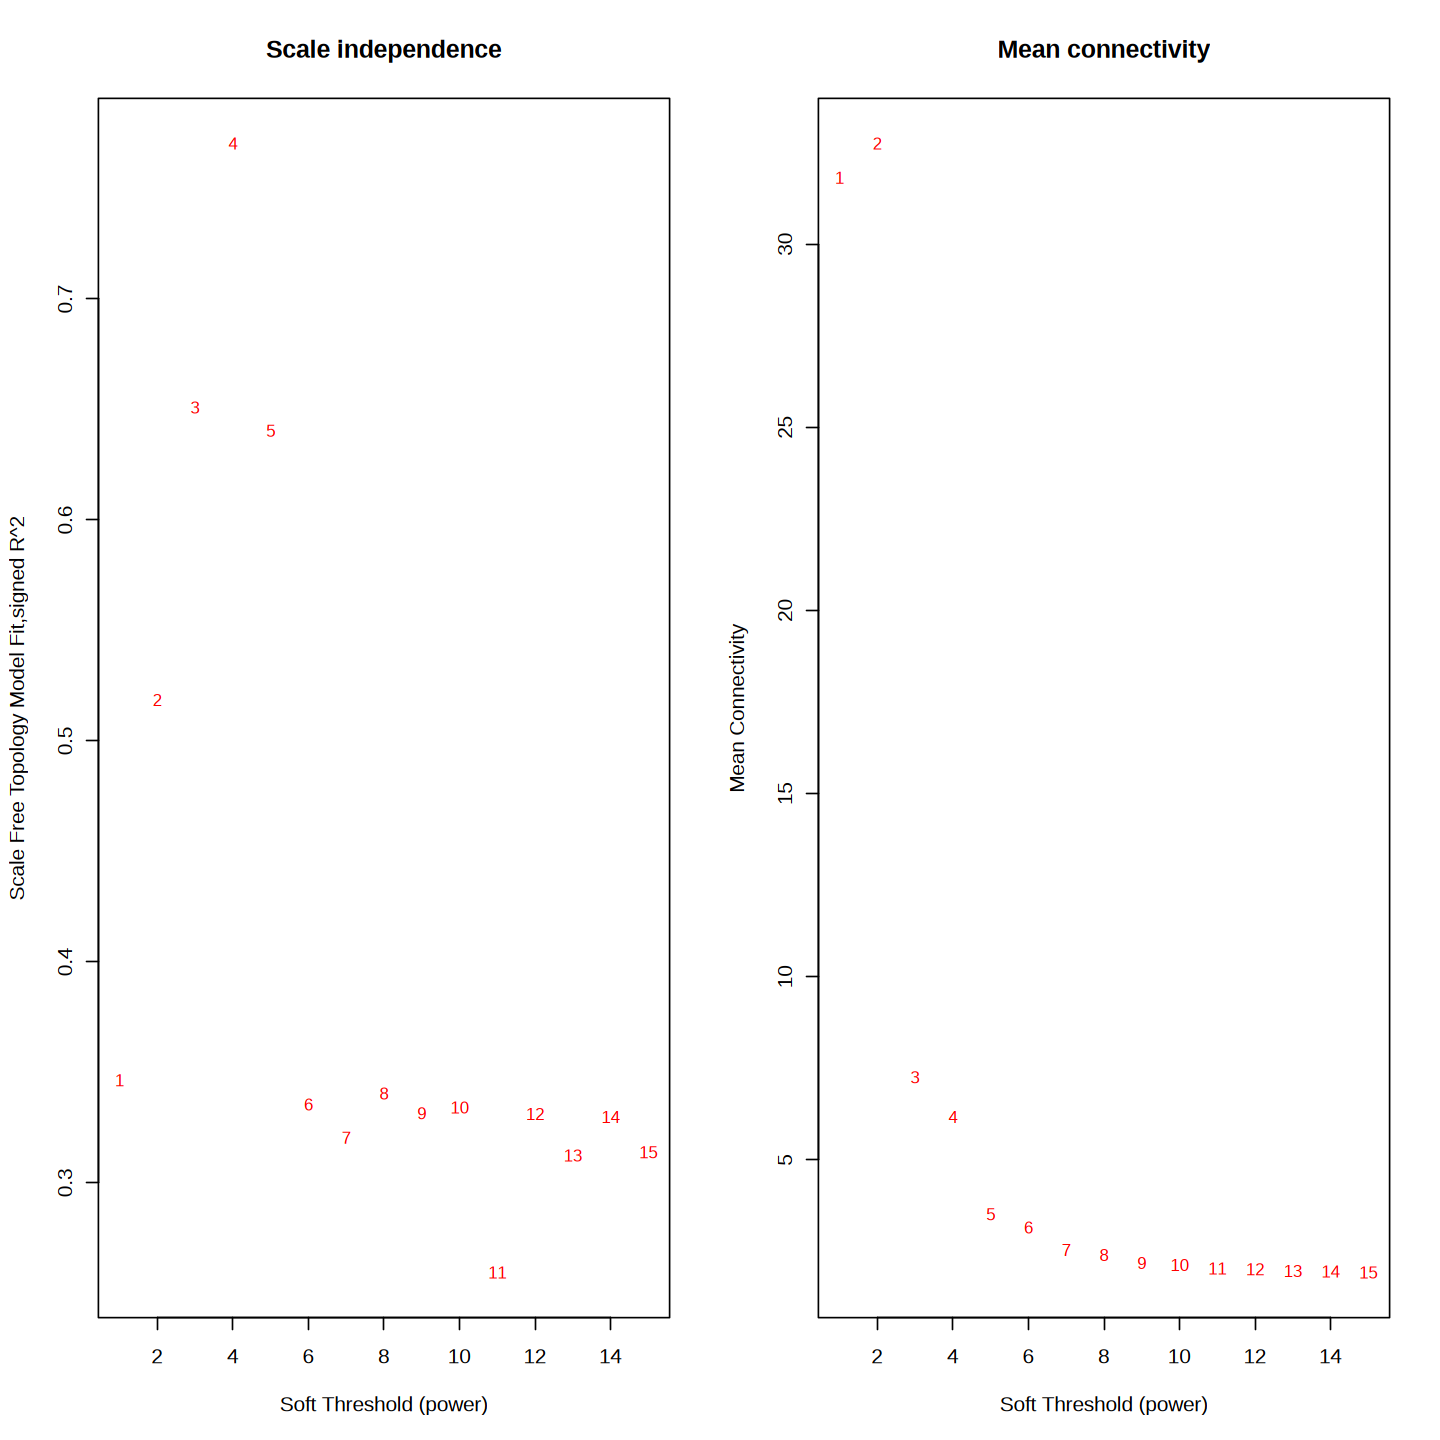

In [22]:
#sizeGrWindow(9, 5)
par(mfrow = c(1,2));
cex1 = 0.8;
# Scale-free topology fit index as a function of the soft-thresholding power
plot(sft$fitIndices[,1], -sign(sft$fitIndices[,3])*sft$fitIndices[,2],
     xlab="Soft Threshold (power)",ylab="Scale Free Topology Model Fit,signed R^2",type="n",
    main = paste("Scale independence"));
text(sft$fitIndices[,1], -sign(sft$fitIndices[,3])*sft$fitIndices[,2],
    labels=powers,cex=cex1,col="red");
# this line corresponds to using an R^2 cut-off of h
abline(h=0.80,col="red")

# Mean connectivity as a function of the soft-thresholding power
plot(sft$fitIndices[,1], sft$fitIndices[,5],
    xlab="Soft Threshold (power)",ylab="Mean Connectivity", type="n",
    main = paste("Mean connectivity"))
text(sft$fitIndices[,1], sft$fitIndices[,5], labels=powers, cex=cex1,col="red")

In [23]:
#based on the prior threshold search, we choose the one that best approximates a scale free topology while still maintaining high level of connectivity
#in the network
softPower = 4;


[1] "nrow: 1217"
..connectivity..
..matrix multiplication (system BLAS)..
..normalization..
..done.
[1] "nrow: 1217"


0.0000000,0.8594744,0.9055442,0.8484911,0.8731713,0.9201193,0.8907800,0.8873958,0.8965620,0.9264023,⋯,0.9276551,0.8851085,0.8877683,0.8829103,0.8902754,0.8647711,0.8827006,0.8651724,0.8636806,0.8911048
0.8594744,0.0000000,0.9223442,0.8691143,0.9007126,0.9287815,0.8915657,0.9121966,0.8980913,0.9321086,⋯,0.9363616,0.8993201,0.9032693,0.9091068,0.9163381,0.8949752,0.9085308,0.8952366,0.8932236,0.9063945
0.9055442,0.9223442,0.0000000,0.9078082,0.9258880,0.9313238,0.9087605,0.9232902,0.9084444,0.9348363,⋯,0.9274825,0.9082467,0.9304034,0.9284973,0.9044504,0.9133346,0.9292874,0.9275437,0.9251550,0.9265493
0.8484911,0.8691143,0.9078082,0.0000000,0.8785897,0.9113617,0.9039102,0.8913307,0.9087927,0.9182547,⋯,0.9224381,0.8965502,0.8999549,0.8871708,0.8973461,0.8695521,0.8882442,0.8811877,0.8818490,0.8993741
0.8731713,0.9007126,0.9258880,0.8785897,0.0000000,0.9329796,0.8977002,0.9224992,0.9015721,0.9373421,⋯,0.9346506,0.9070941,0.9203785,0.9216852,0.9132315,0.8999949,0.9220847,0.9147516,0.9114030,0.9191643
0.9201193,0.9287815,0.9313238,0.9113617,0.9329796,0.0000000,0.9247547,0.9394743,0.9255871,0.9188072,⋯,0.9232367,0.9200228,0.9348144,0.9332341,0.9349917,0.9243262,0.9411758,0.9391113,0.9388982,0.9429652


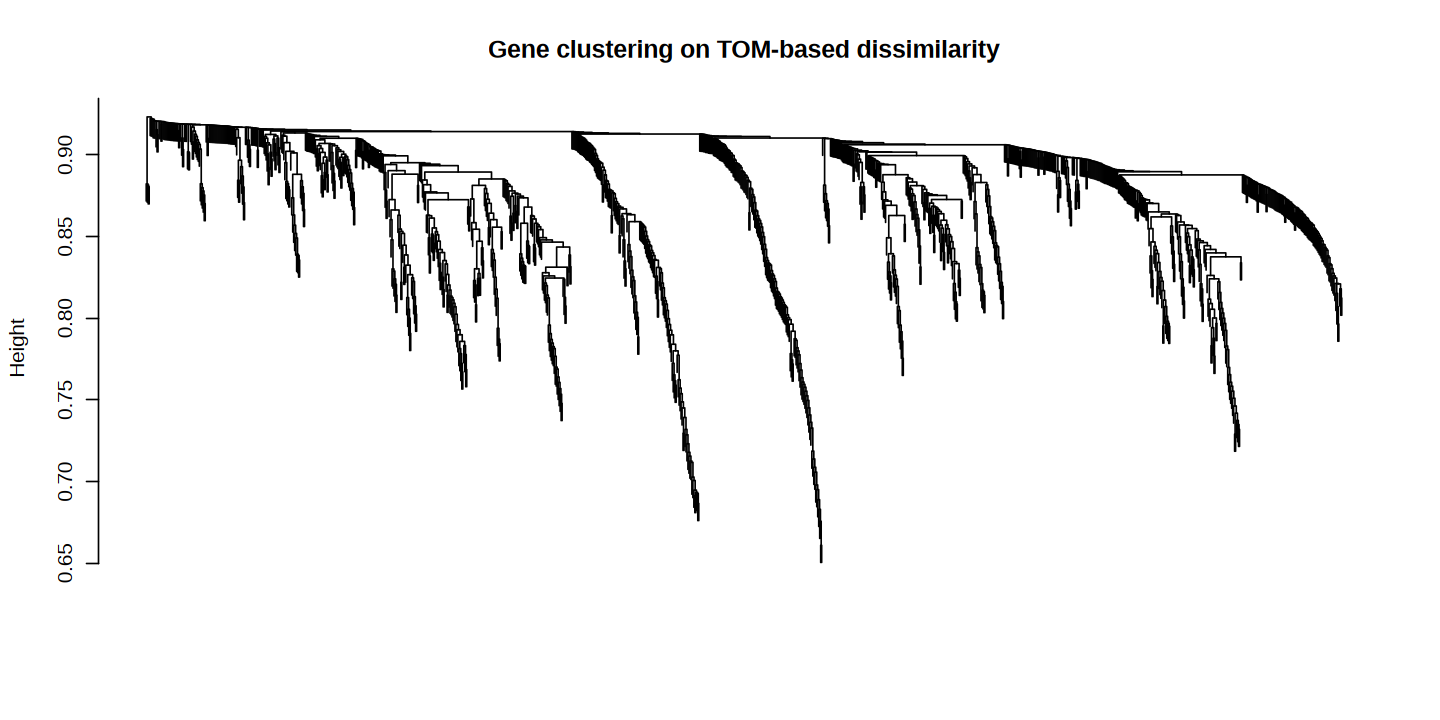

In [24]:
#Generate the adjacency matrix using the chosen soft-thresholding power
adjacency <- adjacency.fromSimilarity(similarity = Zc, type = "signed", power = softPower)

print(str_c("nrow: ", nrow(adjacency)))

#Turn adjacency into topological overlap
##You can input whatever matrix you want here!
TOM <- TOMsimilarity(adjacency, TOMType="signed")

#Turn into distance matrix
dissTOM <- 1 - TOM

print(str_c("nrow: ", nrow(dissTOM)))
head(dissTOM)

#Call the hierarchical clustering function
geneTree <- hclust(as.dist(dissTOM), method="average")

#Plot the resulting clustering tree (dendrogram)
options(repr.plot.width=12, repr.plot.height=6)
plot(geneTree, xlab="", sub="", main="Gene clustering on TOM-based dissimilarity",
     labels=FALSE, hang=0.04)

[1] "minClusterSize = 20"
 ..cutHeight not given, setting it to 0.922  ===>  99% of the (truncated) height range in dendro.
 ..done.


dynamicMods
  1   2   3   4   5   6   7   8   9  10  11  12  13  14 
217 200 128 124 117 111  56  53  42  41  37  36  31  24 

dynamicColors
      black        blue       brown        cyan       green greenyellow 
         56         200         128          24         117          37 
    magenta        pink      purple         red      salmon         tan 
         42          53          41         111          31          36 
  turquoise      yellow 
        217         124 

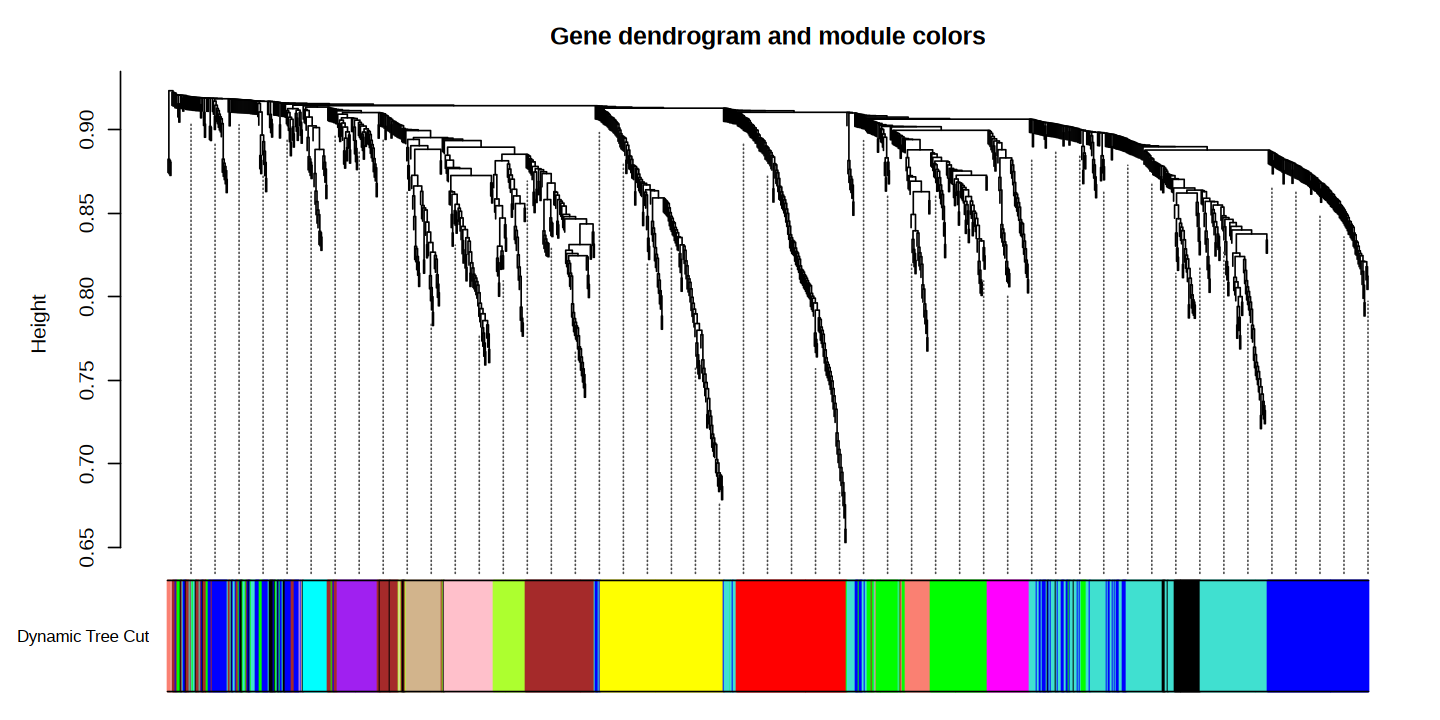

In [25]:
#Larger modules can be easier to interpret, so we set the minimum module size relatively high
minModuleSize <- max(c(20, round(ncol(all_df)/200, digits=0)))
print(str_c("minClusterSize = ", minModuleSize))

#Module identification using dynamic tree cut
dynamicMods <- cutreeDynamic(dendro=geneTree, distM=dissTOM,
                             deepSplit=4, pamStage=TRUE, pamRespectsDendro=FALSE,
                             minClusterSize=minModuleSize)
table(dynamicMods)

#Convert numeric lables into colors
dynamicColors <- labels2colors(dynamicMods)
table(dynamicColors)

#Plot the dendrogram and colors underneath
options(repr.plot.width=12, repr.plot.height=6)
plotDendroAndColors(geneTree, dynamicColors, "Dynamic Tree Cut",
                    dendroLabels=FALSE, hang=0.03,
                    addGuide=TRUE, guideHang=0.05,
                    main="Gene dendrogram and module colors")

[1] "nrow: 900"


,MEblack,MEblue,MEbrown,MEcyan,MEgreen,MEgreenyellow,MEmagenta,MEpink,MEpurple,MEred,MEsalmon,MEtan,MEturquoise,MEyellow
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
01001621,-0.017738940,0.002862359,0.015671549,0.04802711,-0.009241020,0.0036245136,-0.03294559,-0.0006179153,0.005075999,-0.023454074,-0.005853598,-0.03155368,-0.025812783,-0.004247597
01003555,0.015467432,0.009741373,0.045601382,0.11339546,0.007293314,-0.0001515734,0.02125038,0.0144852757,0.012773937,0.018688399,-0.012895599,-0.01990037,0.013243997,-0.020276795
01003758,0.026911221,-0.020050505,-0.001360100,-0.03079578,-0.044513267,-0.0049323879,-0.02530996,-0.0119877446,-0.024022804,0.002848132,-0.021911222,-0.01140331,-0.021798957,0.054641643
01004551,0.007803693,0.014710742,0.001216834,-0.03035441,-0.014667968,0.0013427162,-0.04644682,-0.0007860433,0.006040353,-0.041531626,-0.028713939,-0.03633391,-0.020225581,-0.038762754
01004760,0.057367770,0.013932181,0.059065716,0.01986998,-0.005799998,0.0066781195,0.02275377,0.0165966732,0.058089270,-0.011300421,-0.017893383,0.04420058,0.003259055,0.002709126
01006225,0.022135895,-0.005777182,-0.015850004,-0.01764001,0.029872756,-0.0191385325,-0.05908789,0.0001788883,0.027496093,0.011576763,-0.007047402,-0.03976877,0.004318709,-0.014619189


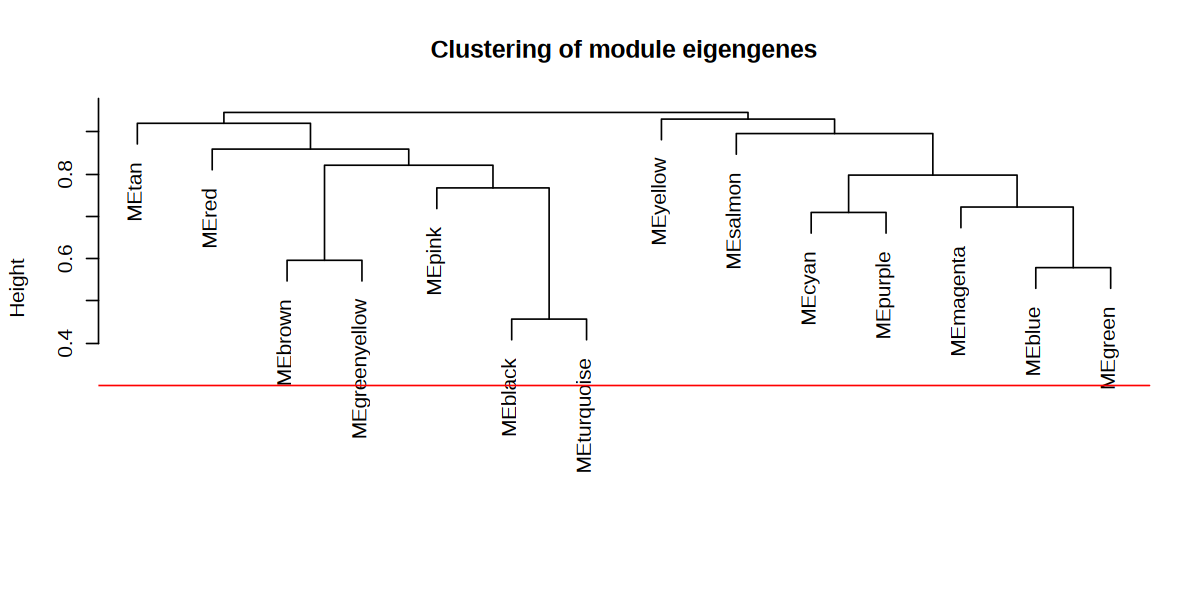

In [26]:
#Calculate eigengenes
MEList <- moduleEigengenes(all_df, colors=dynamicColors, impute=TRUE, nPC=2)
MEs <- MEList$eigengenes
print(str_c("nrow: ", nrow(MEs)))
head(MEs)

#Calculate dissimilarity of module eigengenes
MEDiss <- 1 - cor(MEs, use="pairwise.complete.obs")

#Cluster module eigengenes
METree <- hclust(as.dist(MEDiss), method="average")

#Plot the result
options(repr.plot.width=10, repr.plot.height=5)
plot(METree, main="Clustering of module eigengenes",
     xlab="", sub="")
MEDissThres <- 0.3
abline(h=MEDissThres, col="red")

## Clean data frames

In [27]:
#Clean the module eigengene table
eigengene_df <- MEs %>%
    rownames_to_column(var="public_client_id")
names(eigengene_df)[2:ncol(eigengene_df)] <- names(eigengene_df)[2:ncol(eigengene_df)] %>%
    str_replace(., "^ME", "") %>%
    str_to_title(.)

##Sample metadata
sample_tbl <- fr_measures %>%
    dplyr::filter(public_client_id %in% rownames(MEs)) %>%
    dplyr::arrange(public_client_id)#Sort row order
print("Sample metadata")
print(str_c("- nrow: ", nrow(sample_tbl)))

#Filter metadata to match columns in filtered data frame
sample_tbl <- sample_tbl %>%
    dplyr::filter(public_client_id %in% rownames(MEs))
print("Sample metadata after the filter")
print(str_c("- nrow: ", nrow(sample_tbl)))

#Code sex and race
phenotype_tbl <- sample_tbl %>%
    dplyr::mutate(BinarySex=ifelse(sex=="F", 0, 1),
                  BinaryRace=ifelse(race=="white", 0, 1)) %>%
    dplyr::mutate(BinaryRace=tidyr::replace_na(.$BinaryRace, 1)) %>%#Due to the existence of NA
    dplyr::select(public_client_id, BinarySex, BinaryRace, age, self_fi, lab_fi, merge_fi) %>%
    #Transform tibble for easily applying to the WGCNA functions
    column_to_rownames(var="public_client_id")

#Check phenotypes
print("Sample metadata")
print(str_c("- nrow: ", nrow(phenotype_tbl)))
print("- Contingency of BinarySex")
table(phenotype_tbl$BinarySex)
print("- Contingency of BinaryRace")
table(phenotype_tbl$BinaryRace)

[1] "Sample metadata"
[1] "- nrow: 900"
[1] "Sample metadata after the filter"
[1] "- nrow: 900"
[1] "Sample metadata"
[1] "- nrow: 900"
[1] "- Contingency of BinarySex"



  0   1 
577 323 

[1] "- Contingency of BinaryRace"



  0   1 
711 189 

## Module-trait relationship

[1] "Matched IDs?: TRUE"
[1] "Module–trait relationship table"
[1] "nrow: 14"
[1] "Module–trait relationship p-value table"
[1] "- nrow: 14"
[1] "Module–trait relationship adjusted p-value table"
[1] "- nrow: 14"


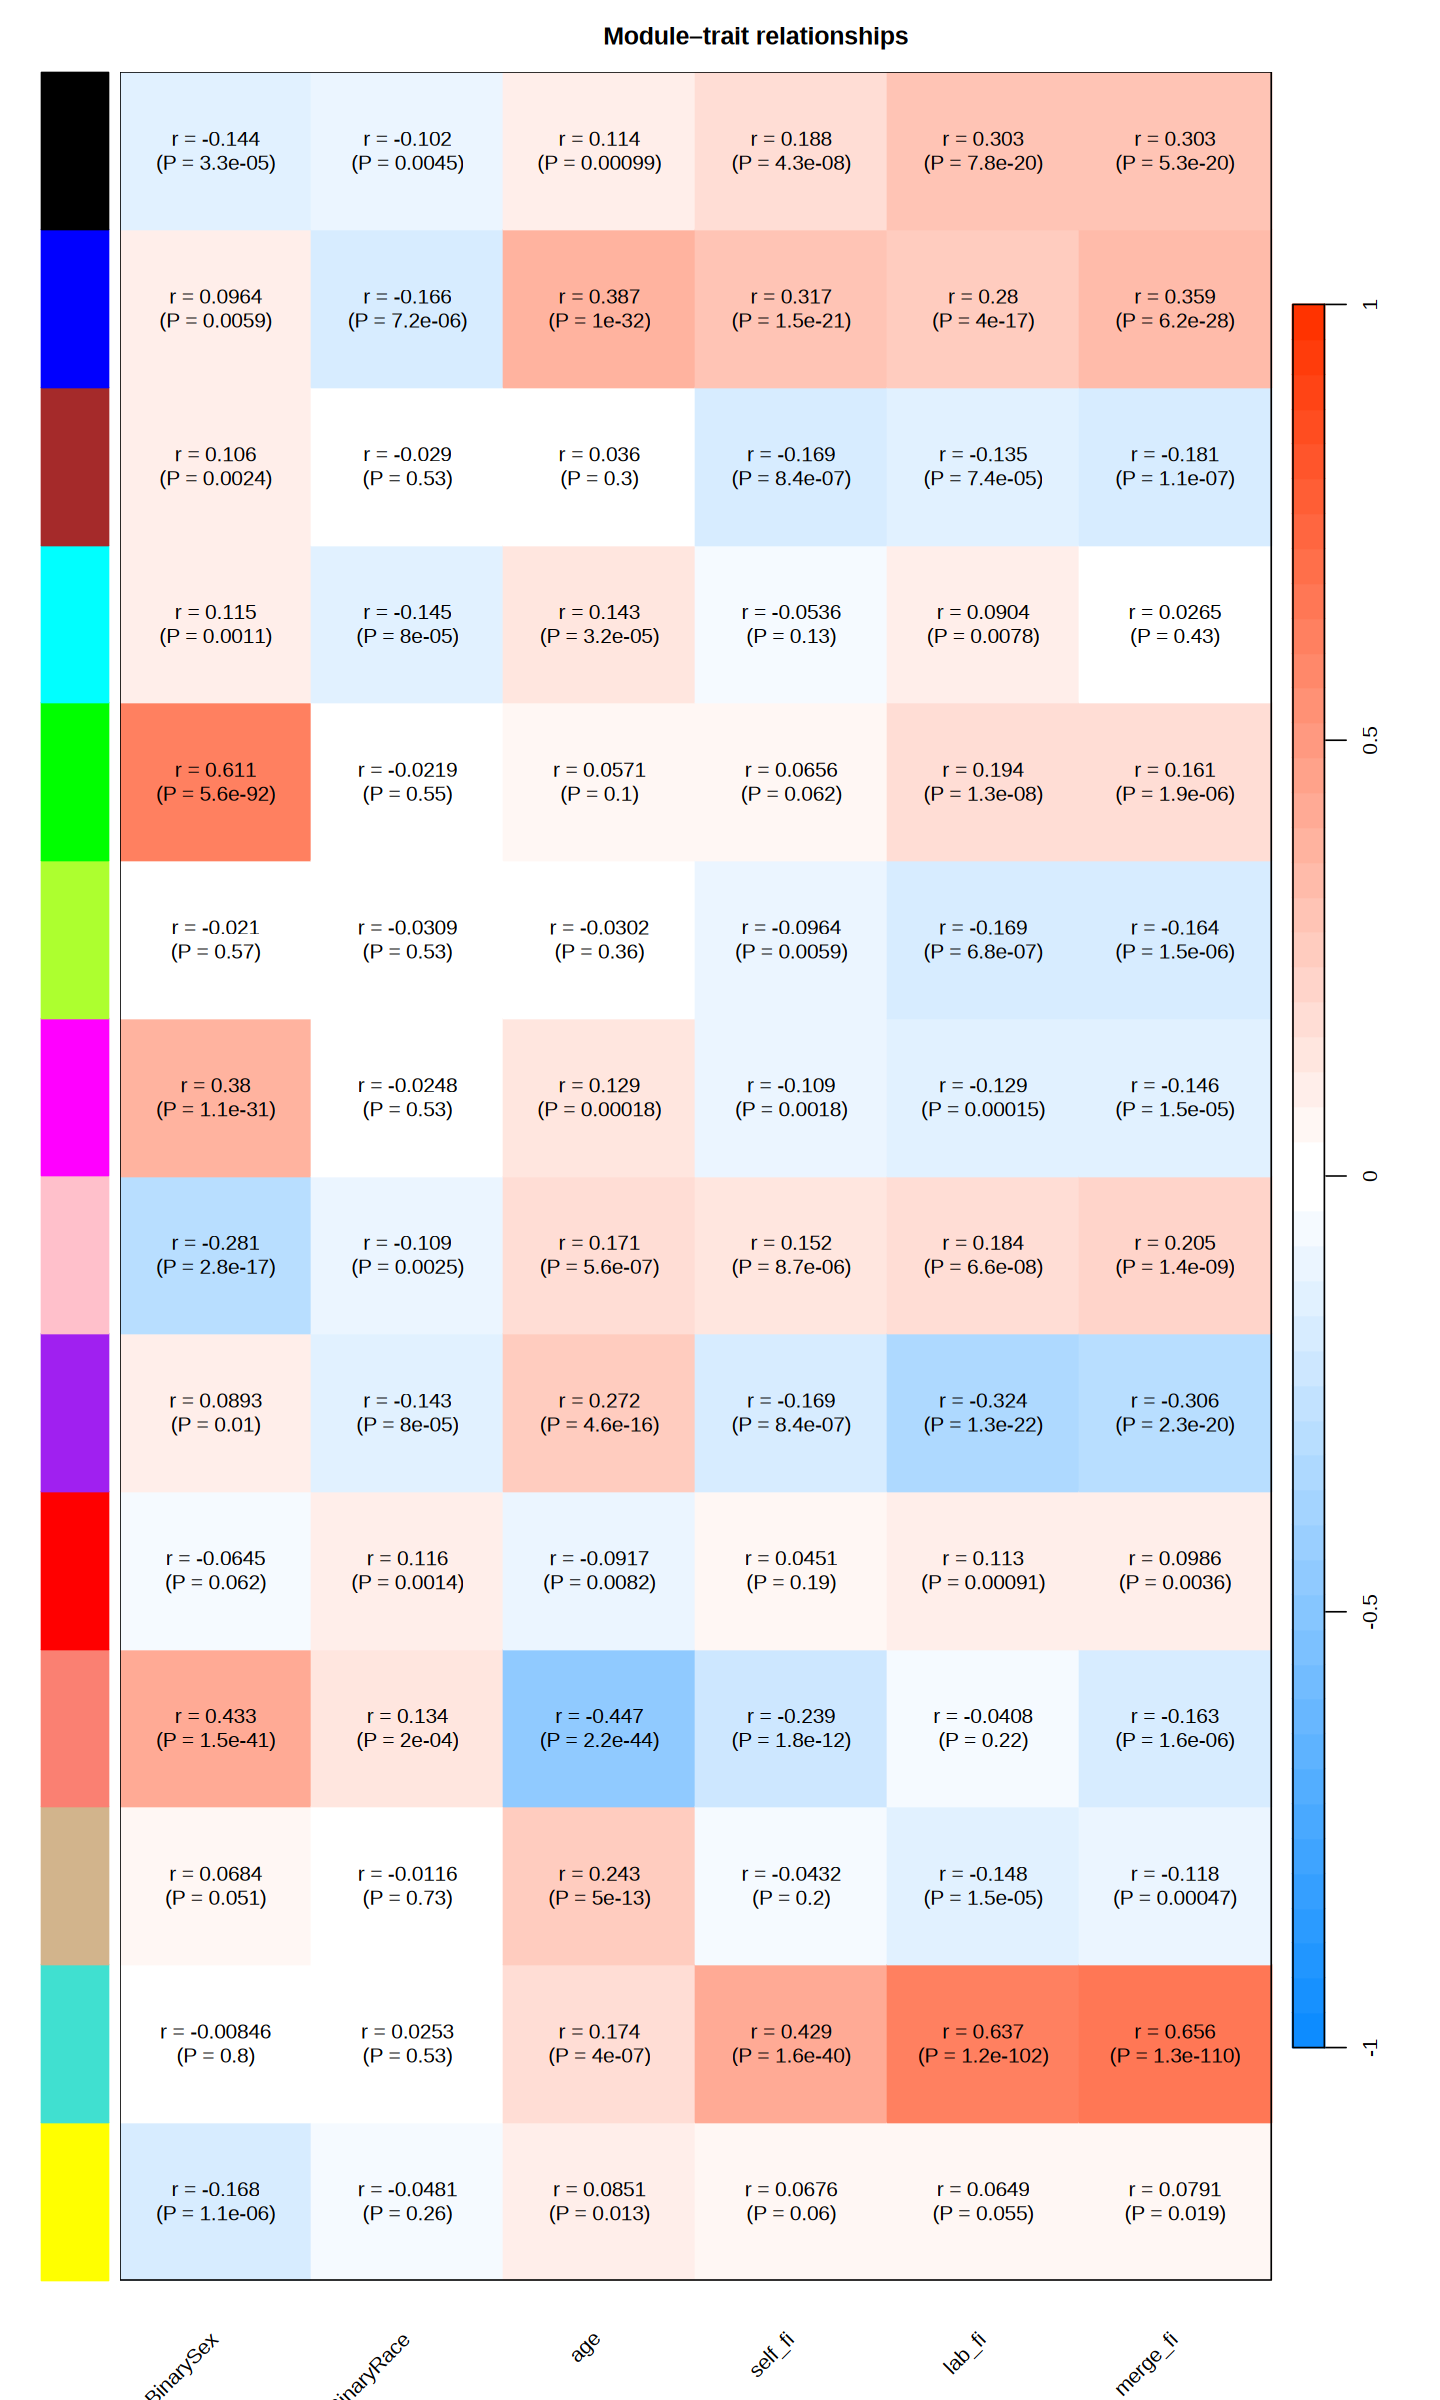

In [28]:
#Calculate the numbers of modules and samples
#nModules <- ncol(MEs)
nSamples <- nrow(phenotype_tbl)

#Names (colors) of the modules
modNames = substring(names(MEs), 3)

##Check ID order before the cor() function
print(str_c("Matched IDs?: ", all(rownames(MEs)==rownames(phenotype_tbl))))

#Calculate module–trait relationship
moduleTraitCor <- as.data.frame(cor(MEs, phenotype_tbl, use="p"))
rownames(moduleTraitCor) <- str_to_title(modNames)
print("Module–trait relationship table")
print(str_c("nrow: ", nrow(moduleTraitCor)))

#Calculate statisitcal significance of module–trait relationship
MTRpval <- as.data.frame(corPvalueStudent(as.matrix(moduleTraitCor), nSamples))
rownames(MTRpval) <- str_to_title(modNames)
print("Module–trait relationship p-value table")
print(str_c("- nrow: ", nrow(MTRpval)))

#Eliminate the dummy module (Grey)
moduleTraitCor <- moduleTraitCor[rownames(moduleTraitCor)!="Grey",]
MTRpval <- MTRpval[rownames(MTRpval)!="Grey",]

#P-value adjustment across modules (per trait) using Benjamini–Hochberg method
MTRpval_adj <- as.data.frame(apply(MTRpval, 2, function(x){p.adjust(x, length(x), method="BH")}))
print("Module–trait relationship adjusted p-value table")
print(str_c("- nrow: ", nrow(MTRpval_adj)))

#Prepare text labels as matrix
textMatrix <- paste("r = ",signif(as.matrix(moduleTraitCor), 3),"\n(P = ",
                    signif(as.matrix(MTRpval_adj), 2),")", sep="")
dim(textMatrix) <- dim(moduleTraitCor)
#Revert module names back to apply color conversion
temp_c <- rownames(moduleTraitCor) %>%
    str_to_lower(.) %>%
    str_c("ME",.)

#Visualize
options(repr.plot.width=12, repr.plot.height=20)
par(mar=c(5, 5, 3, 2))
labeledHeatmap(Matrix=moduleTraitCor,
               xLabels=colnames(moduleTraitCor),
               yLabels=temp_c,
               #ySymbols=rownames(moduleTraitCor),
               colorLabels=FALSE,
               colors=blueWhiteRed(50),
               textMatrix=textMatrix,
               setStdMargins=FALSE,
               cex.text=1,
               zlim=c(-1,1),
               main=paste("Module–trait relationships"))

In [29]:
analyte_tbl_prot <- meta_protein %>%
    #Prepare the same analyte IDs within the data table
    dplyr::mutate(AnalyteID=str_c(name,"(",gene_name,")"), Dataset="Protein") %>%
    #Clean
    dplyr::rename(AnalyteID_original=name, UniProtID=uniprot, GeneSymbol=gene_name) %>%
    dplyr::select(AnalyteID, Dataset, AnalyteID_original, UniProtID, GeneSymbol)

analyte_tbl_met <- meta_metabolites %>%
    #Prepare the same analyte IDs within the data table
    dplyr::mutate(AnalyteID=str_c(CHEMICAL_ID,"(",BIOCHEMICAL_NAME,")"), Dataset="Metabolite") %>%
    #Clean
    dplyr::rename(ChemID=CHEMICAL_ID, ChemName=BIOCHEMICAL_NAME) %>%
    dplyr::select(AnalyteID, Dataset, ChemID, ChemName, KEGG, HMDB)

analyte_tbl_chem <- tibble(AnalyteID = cat.clin, Dataset="Chemistry")
analyte_tbl_multi <- dplyr::bind_rows(analyte_tbl_prot, analyte_tbl_met)
analyte_tbl_multi <- dplyr::bind_rows(analyte_tbl_multi, analyte_tbl_chem)

#Prepare the module assignment table
module_tbl <- tibble(AnalyteID=colnames(all_df),
                     ModuleID=str_to_title(dynamicColors))
print("Module assignment table (temp)")
print(str_c("- nrow: ", nrow(module_tbl)))
module_tbl <- merge(module_tbl, analyte_tbl_multi, by="AnalyteID")
head(module_tbl)

[1] "Module assignment table (temp)"
[1] "- nrow: 1217"


,AnalyteID,ModuleID,Dataset,AnalyteID_original,UniProtID,GeneSymbol,ChemID,ChemName,KEGG,HMDB
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>
1,100000007(carnitine),Green,Metabolite,NA,NA,NA,1e+08,carnitine,C00318,HMDB00062
2,100000008(benzoate),Turquoise,Metabolite,NA,NA,NA,1e+08,benzoate,C00180,HMDB01870
3,100000010(3-phenylpropionate (hydrocinnamate)),Purple,Metabolite,NA,NA,NA,1e+08,3-phenylpropionate (hydrocinnamate),C05629,HMDB00764
4,100000014(hippurate),Purple,Metabolite,NA,NA,NA,1e+08,hippurate,C01586,HMDB00714
5,100000015(xanthurenate),Green,Metabolite,NA,NA,NA,1e+08,xanthurenate,C02470,HMDB00881
6,100000036(3-methyl-2-oxovalerate),Green,Metabolite,NA,NA,NA,1e+08,3-methyl-2-oxovalerate,C00671,HMDB03736


## Module Membership

In [30]:
#Calculate the numbers of genes and samples
#nGenes <- ncol(data_df)
nSamples <- nrow(all_df)

#Names (colors) of the modules
modNames = substring(names(MEs), 3)

##Check ID order before the cor() function
print(str_c("Matched IDs?: ", all(rownames(MEs)==rownames(all_df))))

#Calculate module membership
geneModuleMembership <- as.data.frame(cor(all_df, MEs, use="p"))
#names(geneModuleMembership) <- paste("MM", modNames, sep="")
names(geneModuleMembership) <- str_to_title(modNames)
print("Module membership table")
print(str_c("- nrow: ", nrow(geneModuleMembership)))
head(geneModuleMembership)

#Calculate statisitcal significance of module membership
MMpval <- as.data.frame(corPvalueStudent(as.matrix(geneModuleMembership), nSamples))
names(MMpval) <- str_to_title(modNames)
print("Module membership p-value table")
print(str_c("- nrow: ", nrow(MMpval)))

[1] "Matched IDs?: TRUE"
[1] "Module membership table"
[1] "- nrow: 1217"


,Black,Blue,Brown,Cyan,Green,Greenyellow,Magenta,Pink,Purple,Red,Salmon,Tan,Turquoise,Yellow
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
CVD2_O00182(LGALS9),0.11498035,0.63870587,-0.17161355,-0.021612558,0.16449828,-0.18766807,-0.025400782,0.13986450,-0.039440185,0.24734222,-0.155746609,-0.12518197,0.5632211,0.14640353
CVD2_O00220(TNFRSF10A),0.18410074,0.45010463,-0.07130336,-0.002472948,0.01574536,-0.11500906,-0.130920293,0.05677760,-0.112116412,0.26955944,-0.181582623,-0.09838625,0.4898673,0.12320635
CVD2_O00253(AGRP),0.02941334,0.16040161,0.15790687,0.031935468,0.14947195,-0.02449902,0.132844940,-0.01999847,0.008141956,0.17810710,0.390919721,-0.03718974,0.1331066,0.05645812
CVD2_O14763(TNFRSF10B),0.12797284,0.61968484,-0.05999887,0.034294379,0.16890358,-0.07909468,-0.012075464,0.08693534,0.109128203,0.09497158,-0.189680919,-0.08613862,0.3937360,0.09322385
CVD2_O14836(TNFRSF13B),0.01313985,0.39869320,-0.01069962,-0.077708853,0.07798896,-0.07008618,0.007530161,0.01670957,0.022129968,0.24801359,-0.003811433,-0.10024703,0.2998761,0.06568120
CVD2_O43915(FIGF),-0.01303137,0.04672594,0.07564479,0.051562228,-0.14303910,0.05799560,0.001588624,0.06396073,0.199155432,-0.02098304,-0.150072330,0.02035356,-0.1197275,0.07551998


[1] "Module membership p-value table"
[1] "- nrow: 1217"


In [ ]:
table(module_tbl$ModuleID, module_tbl$Dataset)

## Multiomic enrichment

In [ ]:
geneModuleMembership %>% rownames_to_column(var="AnalyteID")
MMpval %>% rownames_to_column(var="AnalyteID")
colnames(MMpval)[2:ncol(MMpval)] <- paste0(colnames(MMpval)[2:ncol(MMpval)], "_pval")
df.enrich <- merge(module_tbl, geneModuleMembership, by="AnalyteID")
df.enrich <- merge(df.enrich, MMpval, by="AnalyteID")

In [ ]:
prots.enrich <- df.enrich %>% dplyr::filter(Dataset %in% "Protein")
mets.enrich <- df.enrich %>% dplyr::filter(Dataset %in% "Metabolite")
mets.enrich.HMDB <- mets.enrich %>% dplyr::filter(!is.na(HMDB))
print("All metabolites")
print(str_c("- nrow: ", nrow(mets.enrich)))
print("Metabolites with HMDB annotation")
print(str_c("- nrow: ", nrow(mets.enrich.HMDB)))

In [ ]:
# create data structure
omics_data <- initOmicsDataStructure(layer = c(
  "proteome",
  "metabolome"
))
## add proteome layer
omics_data$proteome <- rankFeatures(prots$Turquoise, prots$Turquoise_pval)
names(omics_data$proteome) <- prots$UniProtID
## add metabolome layer
## HMDB features have to be updated to the new HMDB format
omics_data$metabolome <-  rankFeatures(mets_f$Turquoise, mets_f$Turquoise_pval)
names(omics_data$metabolome) <- mets_f$HMDB
names(omics_data$metabolome) <- gsub(
  "HMDB", "HMDB00",
  names(omics_data$metabolome)
)
omics_short <- lapply(names(omics_data), function(name) {
  head(omics_data[[name]])
})
names(omics_short) <- names(omics_data)
omics_short

### Load Pathways and filter

In [ ]:
pathways <- readRDS("../Useful_Files/KEGG_REACTOME_pathways.rds")
pathways_short <- lapply(names(pathways), function(name) {
  head(pathways[[name]], 2)
})
names(pathways_short) <- names(pathways)
pathways_short

### Remove pathways that do not have an overlapping protein
names(pathways$proteome)
### Loop through list of pathways and keep if the pathway has a value in the protein list
pathways_new_prot <- list()
for(i in names(pathways$proteome)){
  
  if(any(pathways$proteome[[i]] %in% names(omics_data$proteome))){
    print(i)
    #Append to new list
    pathways_new_prot[[i]] <- pathways$proteome[[i]]
  }
}
### Remove pathways that do not have an overlapping metabolite
pathways_new_met <- list()
for(i in names(pathways$metabolome)){
  
  if(any(pathways$metabolome[[i]] %in% names(omics_data$metabolome))){
    print(i)
    #Append to new list
    pathways_new_met[[i]] <- pathways$metabolome[[i]]
  }
}

print("All metabolite pathways")
print(str_c("- nrow: ", length(pathways$metabolome)))
print("Pathways with metabolite in network")
print(str_c("- nrow: ", length(pathways_new_met$metabolome)))

In [ ]:
# Reduced pathway set enrichment
pathways_new <- list(proteome = pathways_new_prot, metabolome = pathways_new_met)
enrichment_scores <- multiGSEA(pathways_new, omics_data)
enrich.df <- extractPvalues(
  enrichmentScores = enrichment_scores,
  pathwayNames = names(pathways_new[[1]])
)
enrich.df$combined_pval <- combinePvalues(enrich.df)
enrich.df$combined_padj <- p.adjust(df$combined_pval, method = "BH")
enrich.df <- cbind(data.frame(pathway = names(pathways_new[[1]])), enrich.df)